<a href="https://colab.research.google.com/github/samueldatasci/Modelling_biosystems/blob/main/Assignment_241124.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NOTES!
- Error in Tau/poles:<br>
On the model_generator function, we simplified the dominant pole, as there was only one pole (a was always equal to 1). In models with a>1, and with more poles, the code in that function needs to change.
### CHECK:
`  dominant_pole = poles`<br>
`  tau = -1 / np.log(dominant_pole)`<br>
(ChatGPT) Aparently, calculating poles does not make sense when a = 0. When a=0, the system is of first order, or purely static, so apparently these concepts do not apply.


# Assignment on Modelling Biosystems, KU Leuven
Produced by: Ricardo Santos


## Student ID
### Name: Ricardo Santos
### Number:
### Email:
##### 2024-12-01


# Initialization for Assignment 1 and Assignment 2

In [1]:
!pip install control
!pip install pymannkendall
# pip install statsmodels


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 9.3 MB/s eta 0:00:00


In [2]:
from google.colab import files
import seaborn as sns
import io
import os
import pandas as pd
import numpy as np
import pymannkendall as mk
import statsmodels.api as sm
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.preprocessing import MinMaxScaler
import control as ctrl
#from sklearn.metrics import mean_absolute_error as mae
#from sklearn.metrics import r2_score
from scipy import signal


In [3]:
# prompt: Connect to google drive.
# Set default dir to '/content/drive/MyDrive/Modelling_biosystems-main/AssignmentData/MOB_Dataset1'

from google.colab import drive
drive.mount('/content/drive')


datafolder_part1 = "/content/drive/MyDrive/Modelling_biosystems-main/AssignmentData/MOB_Dataset1"
datafolder_part2 = "/content/drive/MyDrive/Modelling_biosystems-main/AssignmentData/MOB_Dataset2"

debug = True


Mounted at /content/drive


### Generic functions

In [4]:
def vprint(*args, **kwargs):
    if debug:
        print(*args, **kwargs)


# 1º Practical assignment

In [6]:
def dataloader(data, na, nb, d):
    '''
    Replicates dataset "data" as a new dataset,
    with the lagged features defined by "na", "nb" and "d".

    Parameters:
    data: dataset
    na: number of a parameters
    nb: number of b parameters
    d: delta time

    Return:
    X - input data
    y - output data
    '''

    y = data['y']
    u = data['u']

    # Initialize empty dataframe for lagged features
    X = pd.DataFrame()

    # Create lagged features for output ('a' parameters)
    for i in range(1,na+1):
        X['y-{}'.format(i)] = y.shift(i)
    # Create lagged features for input ('b' parameters)
    for i in range(0,nb):
        X['u-{}'.format(i + d)] = u.shift(i + d)

    #Only select data after a certain row, rows before that will be incomplete
    startpos = max(na,nb+d-1)
    X = X.iloc[startpos:]
    y = y[startpos:]

    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)

    return X, y



def r_2(y, y_hat):
    '''
    Return R2.

    Parameters:
    y - the actual values (ground truth)
    y_hat - the correspondig predictions

    Return:
    r_squared - The calculated R2
    '''

    y_mean = np.mean(y)
    y_hat_mean = np.mean(y_hat)
    sst = np.sum((y - y_mean) ** 2)
    #ssr = np.sum((y - y_hat_mean) ** 2)
    ssr = np.sum((y - y_hat) ** 2)
    r_squared = 1 - (ssr / sst)
    return r_squared




def model_metrics(y_real,y_sim,na,nb):
    '''
    Calculates several metrics for a model, give the parameters

    Parameters:
    y_real: the actual values (ground truth)
    y_sim: the correspondig predictions
    na: number of a parameters
    nb: number of b parameters

    Return:
    r_squared
    aic
    Rmse
    bic
    fpe
    '''

    # Calculate r-squared and AIC and RMSE and BIC and FPE
    k = na + nb # number of parameters
    n = len(y_real)
    SSR = np.sum((y_real - y_sim) ** 2)
    #Calculate useful Model evaluation parameters
    r_squared = r_2(y_real, y_sim)
    aic =  2 * (na + nb) + n * np.log(1 - r_squared) # Evaluates the complexicity of the Model
    Rmse = rmse(y_real, y_sim[0:])  #Root Mean Squared Error (Less sensitive to outliers: It is less affected by extreme errors compared to RMSE)
    fpe = SSR * (n + k) / (n - k)                  #Final Prediction Error(used for model order selection)(Considers both model fit and complexity) (Asymptotically equivalent to AIC: For large sample sizes, FPE and AIC tend to select the same model)
    bic = n * np.log(SSR / n) + k * np.log(n)      #Bayesian Information Criterion (BIC penalizes model complexity more heavily than AIC.)(Consistent: more likely to select the true model when sample is bigger)

    return r_squared, aic, Rmse, bic, fpe


In [18]:
def model_generator(data, na, nb, d):
    '''

    Parameters:
    data - dataset
    na - number of a parameters
    nb - number of b parameters
    d - delta time

    Return:
    y_loader - real values
    ysim - simulated values
    parameters_a - a parameters vector
    parameters_b - b parameters vector
    SSG -
    tau
    r_squared
    aic
    Rmse
    bic
    fpe

    Example invocations:
    y_loader, ysim, parameters_a, parameters_b, SSG, tau, r_squared, aic, Rmse, bic, fpe = model_generator(athlete_list[0], 0, 1, 4)
    y_loader, ysim, parameters_a, parameters_b, SSG, tau, r_squared, aic, Rmse, bic, fpe = model_generator(athlete_list[0], 1, 1, 0)
    y_loader, ysim, parameters_a, parameters_b, SSG, tau, r_squared, aic, Rmse, bic, fpe = model_generator(athlete_list[0], 2, 4, 2)

    '''

    #print(f"Athlete: {code_name[i]}")
    #print('\nGenerating Model with {} a parameters, {} b parameters and {} time delay'.format(na,nb,d))
    #load the associated data using dataloader(data, na, nb, d)
    X_loader, y_loader = dataloader(data, na, nb, d)

    ##Calculate the a and b parameters      #parameters vector [a0...an, b0...bm].T by the formula inv(X.T dot X) dot X.T dot y
    parameters = np.linalg.inv(X_loader.T.dot(X_loader)).dot(X_loader.T).dot(y_loader)
    parameters_a = parameters[:na]
    parameters_b = parameters[na:]

    ## Simulate values of Y
    ysim = np.zeros(len(y_loader)) # the plus one is because the first value is initialized and not simulated
    ysim[0]= y_loader.values[0] # initialize the first value
    max_lag= max(na,nb+d-1)  # Maximum lag across both endogenous and exogenous variables

    for k in range(max_lag, len(X_loader)):
        # Add the contribution from autoregressive terms (endogenous variables)
        for i_a in range(1,na+1): # range starts at 1, because if na=0, we have no parameter_a columns
            #vprint("parameter a: ",i_a)
            ysim[k] += parameters_a[i_a-1] * ysim[k - i_a]  # Note: parameters_a starts at index 0

        # Add the contribution from exogenous input terms (with delay d)

        ##### Sam - comentei este bloco e rescrevi abaixo.
        for j_b in range(nb):
            #vprint("parameter b: ",j_b)
            ysim[k] += parameters_b[j_b] * X_loader['u-{}'.format(d+j_b)].iloc[k-j_b]  # Note: parameters_b starts at index 0
            #vprint('u-{}'.format(d+j_b),j_b,d)

        # for j_b in range(1, nb+1):
        #     ysim[k] += parameters_b[j_b-1] * X_loader['u-{}'.format(d+j_b-1)].iloc[k-j_b]  # Note: parameters_b starts at index 0

    #Used? Needed?
    num = parameters_b # b [b1,b2,b3,...] (exogenous)
    den = [1, -parameters_a] #a [1,a2,a3,...] (endogenous)

    #Calculate SSG(K) and TC
    ##SSG = how much the output of a system changes in response to a change in the input.
    SSG = sum(parameters_b)/ (1 - sum(parameters_a)) #a unit change in the input (u) will result in a 1.33 unit change in the output (y)
    SSG2 = sum(num)/ (sum(den))

    y_mean = np.mean(y_loader)
    #y_hat_mean = np.mean(ysim)
    SSG3 = np.sum((ysim - y_mean) ** 2)


    vprint(f"SSG: {SSG}, SSG2: {SSG2}, SSG3: {SSG3}")
    #Calculate the TC
    #Check if parameters_a has more than one element to avoid the error
    #if len(parameters_a) > 1:
    #    poles = 1/parameters_a[0]
    #else:
    #    poles = 1/parameters_a  # In case parameters_a has only one element


    if parameters_a.size > 0:  # Check if parameters_a is not empty
        if parameters_a.size == 1:
            poles = 1/parameters_a
            dominant_pole = poles
        else:
            poles = 1/parameters_a
            #dominant_pole = poles[np.argmin(np.abs(poles.imag))] #get the dominant
            dominant_pole = poles[np.argmin(np.abs(poles))] #get the dominant
        tau = -1 / np.log(dominant_pole)
    else:
        poles = None
        dominant_pole = None
        tau = None
    # print(f"**** parameters_a: {parameters_a}; poles: {poles}, dominant_pole: {dominant_pole}")

    #poles2 = 1/den[1]

    #Check if poles is an array before calculating dominant_pole
    # if isinstance(poles, np.ndarray):
    #    dominant_pole = poles[np.argmin(np.abs(poles.imag))] #get the dominant
    # else:
    #   dominant_pole = poles  # If poles is a scalar, directly assign to dominant_pole
    # #dominant_pole = poles

    #print("Time constant:", tau)
    #tau2 = -1 / np.log(poles[np.argmin(np.abs(poles.imag))])
    #print("Time constant2:", tau2)


    #Models Stability
    num = parameters_b # b [b1,b2,b3,...] (exogenous)
    den1 =  np.insert(-parameters_a, 0, 1)
    den = [1] + (-parameters_a).tolist() #a [1,a2,a3,...] (endogenous)
    TF = ctrl.TransferFunction(num, den)    #define transfer function
    #  poles, zeroes = ctrl.pzmap(TF, plot=True)  #PLOT CIRCLE AND MODEL (DELETE?CHANGE?)
    #add unit circle
    #plt.gca().add_patch(plt.Circle((0, 0), radius=1, fill=False, color='gray', linestyle='--'))
    #plt.show()
    #New Verions (TESTED, but NOT CONFIRMED TO DO THE SAME)
    #poles, zeroes = ctrl.pole_zero_map(TF)
    #ctrl.pole_zero_plot(TF)         #


    ## Model evaluation for each generated model use r_squared and aic def above
    r_squared, aic, Rmse, bic, fpe = model_metrics(y_loader,ysim,na,nb)

    return y_loader, ysim, parameters_a, parameters_b, SSG, tau, r_squared, aic, Rmse, bic, fpe


## Load files from disk

In [10]:
# uploaded = files.upload()
os.chdir(datafolder_part1)


In [11]:
A1M1_df = pd.read_csv('MOB_Dataset1_A1_M1.csv', names=['y','u'])
A1M2_df = pd.read_csv('MOB_Dataset1_A1_M2.csv', names=['y','u'])
A2M1_df = pd.read_csv('MOB_Dataset1_A2_M3.csv', names=['y','u'])
A2M2_df = pd.read_csv('MOB_Dataset1_A2_M4.csv', names=['y','u'])
A3M1_df = pd.read_csv('MOB_Dataset1_A3_M5.csv', names=['y','u'])
A3M2_df = pd.read_csv('MOB_Dataset1_A3_M6.csv', names=['y','u'])
A4M1_df = pd.read_csv('MOB_Dataset1_A4_M7.csv', names=['y','u'])
A4M2_df = pd.read_csv('MOB_Dataset1_A4_M8.csv', names=['y','u'])
A5M1_df = pd.read_csv('MOB_Dataset1_A5_M9.csv', names=['y','u'])
A5M2_df = pd.read_csv('MOB_Dataset1_A5_M10.csv', names=['y','u'])
A6M1_df = pd.read_csv('MOB_Dataset1_A6_M11.csv', names=['y','u'])
A6M2_df = pd.read_csv('MOB_Dataset1_A6_M12.csv', names=['y','u'])

athlete_list = [A1M1_df, A1M2_df, A2M1_df, A2M2_df, A3M1_df, A3M2_df, A4M1_df, A4M2_df, A5M1_df, A5M2_df, A6M1_df, A6M2_df]
code_name = ['A1M1', 'A1M2', 'A2M1', 'A2M2', 'A3M1', 'A3M2', 'A4M1', 'A4M2', 'A5M1', 'A5M2', 'A6M1', 'A6M2']



In [12]:
dictathlete = {}
for i in range(len(athlete_list)):
    dictathlete[code_name[i]] = athlete_list[i]


## Data exploration

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns


In [20]:
k_xlabel = "Input (u) 3-D activity in GU"
k_ylabel = 'Output (y) Heart rate in BPM'
k_axis = [0.0, 2.7, 70.0, 210.0]


### Plot data for all players of each game

In [ ]:
colors = ["Red", "Blue", "Green", "Orange", "Purple", "Yellow"] # Colors for each athlete
marker = '.'


for game in range(2):
    plt.figure(figsize=(10, 8))
    for athl in range(6):
        plt.scatter(athlete_list[athl*2+game]['u'], athlete_list[athl*2+game]['y'], label=code_name[athl*2+game], color=colors[athl], marker=marker, s=10)

    plt.xlabel(k_xlabel)
    plt.ylabel(k_ylabel)
    plt.axis( k_axis)
    plt.title(f'Game #{game} for all athletes')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.grid(True)
    plt.show()



### Plot data for both games of each player

In [ ]:
colors = ['green', 'red']  # Colors for each game of the athlete
colors = ["#00407A", '#54BCEB']  # KU Leuven!

marker = '.'

for athl in range(6):
    firstgame = athl * 2
    plt.figure(figsize=(10, 8));  # Create figure with desired size before plotting

    for game in range(2):
        plt.scatter(athlete_list[firstgame + game]['u'], athlete_list[firstgame + game]['y'], label=code_name[firstgame + game], color=colors[game], marker=marker, s=10)

    plt.xlabel(k_xlabel)
    plt.ylabel(k_ylabel)
    plt.axis(k_axis)

    plt.title(f'Athlete {athl + 1}')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.grid(True)

    plt.show()

In [ ]:
colors = ['green', 'red']  # Colors for each game of the athlete
colors = ["#00407A", '#54BCEB']  # KU Leuven!
marker = '.'

sns.set_style("whitegrid")  # Set a visually appealing style

fig, axes = plt.subplots(2, 3, figsize=(24, 12))  # Create a 3x2 grid of subplots

for athl in range(6):
    firstgame = athl * 2
    row = athl // 3  # Calculate row index
    col = athl % 3   # Calculate column index
    ax = axes[row, col]  # Get the current subplot

    for game in range(2):
        ax.scatter(athlete_list[firstgame + game]['u'], athlete_list[firstgame + game]['y'],
                   label=code_name[firstgame + game], color=colors[game], marker=marker, s=10, alpha=0.7)

    ax.set_xlabel(k_xlabel, fontsize=14)
    ax.set_ylabel(k_ylabel, fontsize=14)
    ax.axis(k_axis)

    ax.set_title(f'Athlete {athl + 1}', fontsize=18, fontweight='bold')
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1), fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)

    sns.despine(ax=ax)  # Remove spines for the current subplot
    plt.tight_layout()

plt.show()


In [ ]:

# Define colors and markers for each athlete
colors = ['blue', 'blue', 'red', 'red', 'green', 'green', 'purple', 'purple', 'orange', 'orange', 'brown', 'brown']
markers = ['.', 'x', '.', 'x', '.', 'x', '.', 'x', '.', 'x', '.', 'x']  # Dot for M1, x for M2


plt.figure(figsize=(10, 8))  # Adjust figure size as needed

# Iterate through datasets and create scatter plots with specified colors and markers
for i, dataset in enumerate(athlete_list):

    plt.scatter(dataset['u'], dataset['y'], label=code_name[i], color=colors[i], marker=markers[i], s=10)  # s controls marker size

plt.xlabel('Input (u)')
plt.ylabel('Output (y)')
plt.title('Scatter Plot for All Athletes')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1)) # Adjust legend location if needed
plt.grid(True)
plt.show()

In [ ]:
#scatter plot all dfs
#import matplotlib.pyplot as plt

# Iterate through the datasets and create scatter plots
for i, dataset in enumerate(athlete_list):
    plt.figure(figsize=(8, 6))  # Adjust figure size as needed
    plt.scatter(dataset['u'], dataset['y'], label=code_name[i], marker=".", s=10)
    plt.title(f'Scatter Plot for {code_name[i]}')
    plt.xlabel('Input (u)')
    plt.ylabel('Output (y)')
    plt.title(f'Scatter Plot for {code_name[i]}')
    plt.legend()
    plt.grid(True)
    plt.show()



## Data exploration - check the covariance

In [21]:
# Calculate and print individual covariance matrices
# for i, dataset in enumerate(athlete_list):
#     covariance_matrix = np.cov(dataset['u'], dataset['y'])
#     print(f"Covariance Matrix for {code_name[i]}:\n{covariance_matrix}\n")

# Create a table of covariances
covariance_data = []
for i, dataset in enumerate(athlete_list):
    covariance_matrix = np.cov(dataset['u'], dataset['y'])
    covariance_data.append([code_name[i], covariance_matrix[0, 1]])  # Extract covariance between 'u' and 'y'

covariance_table = pd.DataFrame(covariance_data, columns=['Athlete', 'Covariance'])
print("\nCovariance Table:\n", covariance_table)



Covariance Table:
    Athlete  Covariance
0     A1M1    1.662819
1     A1M2    1.283243
2     A2M1    1.207343
3     A2M2    1.255750
4     A3M1    0.975573
5     A3M2    1.348638
6     A4M1    1.355412
7     A4M2    1.899733
8     A5M1    3.938292
9     A5M2    1.133550
10    A6M1    0.957688
11    A6M2    0.802858


## Preprocessing

In [22]:
athlete_list[8]

y     u
0     120  0.11
1     125  0.19
2     131  0.14
3     132  0.17
4     130  0.13
...   ...   ...
6818  100  0.12
6819  102  0.06
6820  103  0.04
6821  104  0.03
6822  105  0.03

[6823 rows x 2 columns]

# TODO!
Here I still have to choose which line to keep for each axis; either the actual or the moving average.<br>
Or: That may just become parameters; if averagex > 1, moving average, else, just use x.
Same for y.

In [ ]:
#1ºData Preparation
#Pre-processing

#High frequency disturbances (too high measurement frequency -> Downsampling)
#1ºlow pass filter | 2º Downsampling


#Outliers


In [26]:
def chart_athlete_game(athlete=1, game=1, normalize_u=True, normalize_y=True, window_mov_avg_u = 1, window_mov_avg_y = 1):
    '''Graphically one athlete and one game.
    Data is normalized by subtracting the mean.

    Parameters:
    athlete - athlete number
    game - game number
    normalize - if True, subtract the mean from the data
    window_mov_avg - window size for the moving average. If 1 (default), use the actual value.
    window_mov_avg_y - window size for the moving average. If 1 (default), use the actual value.
    Return:
    None
    '''
    #Outliers
    dataset = athlete_list[(athlete-1)*2 + game-1].copy()
    # print("dataset")
    # print(dataset.head(10))
    # print("-----------")

    # print(f"u: mean(): {np.mean(dataset['u'])}, min(): {np.min(dataset['u'])}, max(): {np.max(dataset['u'])}")
    # print(f"y: mean(): {np.mean(dataset['y'])}, min(): {np.min(dataset['y'])}, max(): {np.max(dataset['y'])}")
    # print(f"U: mean(): {dataset['u'].mean()}, min(): {dataset['u'].min()}, max(): {dataset['u'].max()}")
    # print(f"Y: mean(): {dataset['y'].mean()}, min(): {dataset['y'].min()}, max(): {dataset['y'].max()}")

    # Center values around zero
    if normalize_u:
        dataset['u'] = dataset['u'] - np.mean(dataset['u'])
    if normalize_y:
        dataset['y'] = dataset['y'] - np.mean(dataset['y'])

    mov_avrg_u = dataset['u'].rolling(window=window_mov_avg_u, center=True, min_periods=1).mean()
    mov_avrg_y = dataset['y'].rolling(window=window_mov_avg_y, center=True, min_periods=1).mean()


    trend = mk.original_test(dataset['y'])

    #plot
    fig, ax1 = plt.subplots(figsize=(20, 6))

    ax1.set_xlabel('X-axis Time')
    ax1.set_ylabel('U1-axis Output', color='blue')
    ax1.tick_params('y', colors='blue')

    ax2 = ax1.twinx()
    ### ax2.plot(dataset['u'], color='green', label='Input')
    if window_mov_avg_u > 1:
        ax2.plot(mov_avrg_u, color='orange', label='Mov-Mean_Input')
    else:
        ax2.plot(mov_avrg_u, color='orange', label='Input')

    ax2.set_ylabel('Y2-axis Input', color='green')
    ax2.tick_params('y', colors='green')


    # Compute the linear trend line
    x_values_trend = range(len(dataset['y']))  # Assuming x-values correspond to indices in the dataset
    linear_trend = [trend.slope * x + trend.intercept for x in x_values_trend]

    # Plot the real output and moving average
    ### ax1.plot(dataset['y'], color='blue', label='Real Output')
    if window_mov_avg_y > 1:
        ax1.plot(mov_avrg_y, color='red', label='Mov-Mean Output')
    else:
        ax1.plot(mov_avrg_y, color='red', label='Output')

    # Add the trend line
    #ax3 = ax1.twinx()
    ax1.plot(linear_trend, color='purple', linestyle='--', label='Trend', linewidth=2)
    # # Add the linear trend line
    #ax1.plot(x_values, linear_trend, color='purple', linestyle='--', label='Linear Trend (y = {:.4f}x + {:.2f})'.format(slope, intercept), linewidth=2)


    fig.legend(loc="upper right")
    ax1.set_title( f'Athlete {athlete} - Game {game}')
    fig.tight_layout()

    #return trend
    return


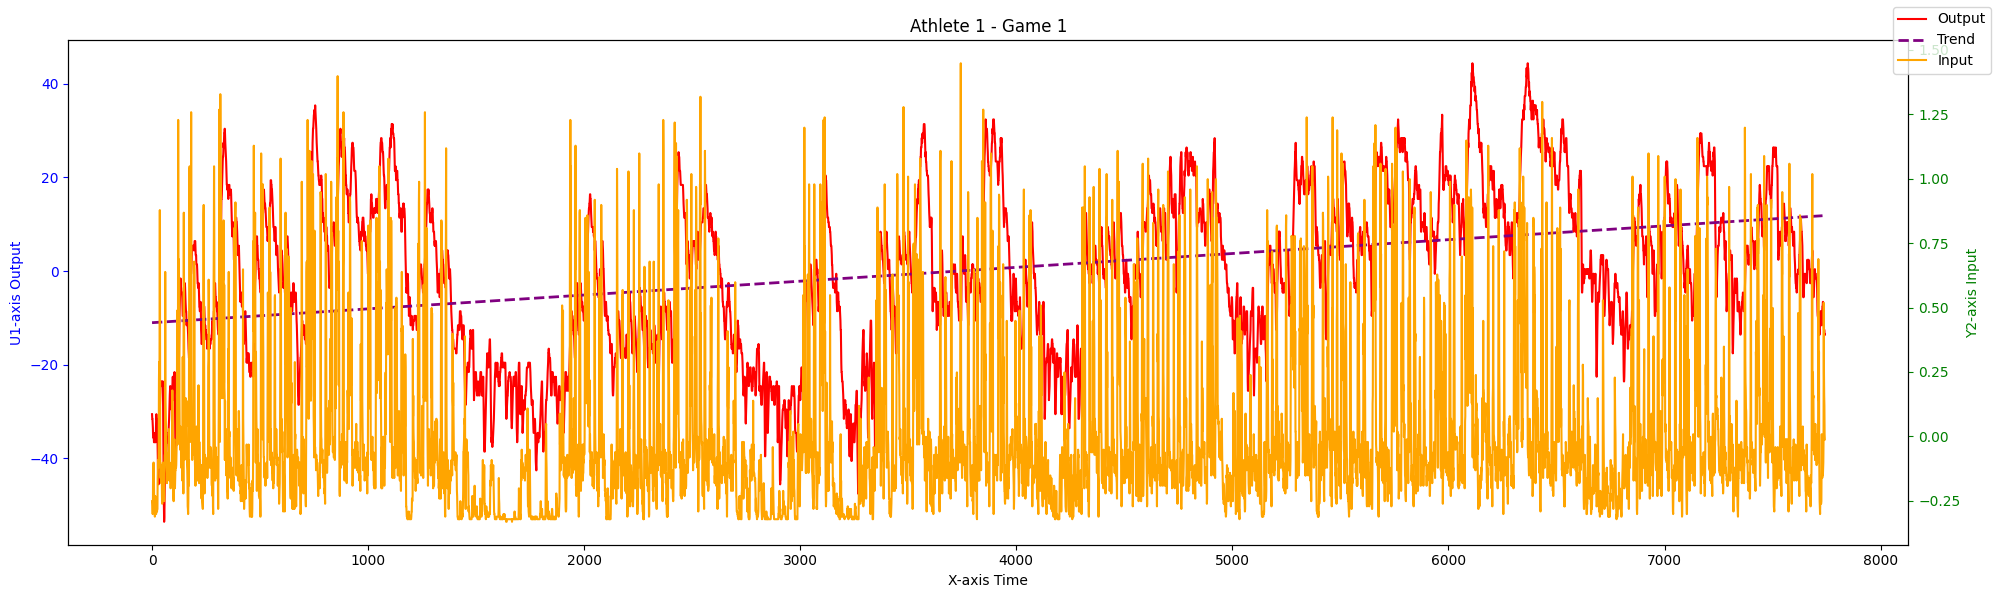

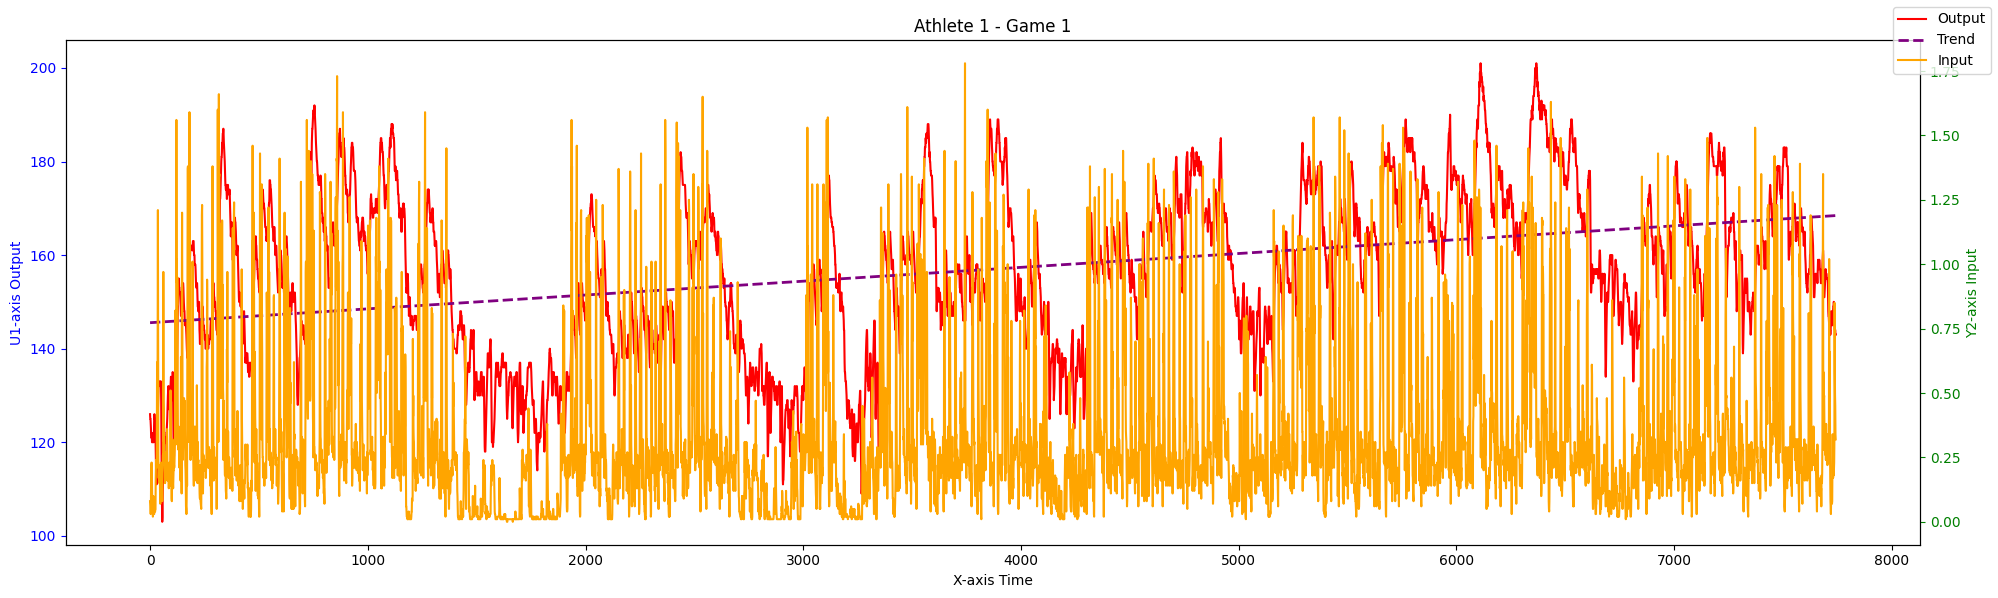

In [24]:
chart_athlete_game(athlete=1, game=1, normalize_u=True, normalize_y=True)
chart_athlete_game(athlete=1, game=1, normalize_u=False, normalize_y=False)



In [ ]:
# ath=4, gm=0
for ath in range(1,7):
    for gm in range(1,3):
        chart_athlete_game(athlete=ath, game=gm)


## I THINK THE CODE BELOW NO LONGER MAKES SENSE...<br>
Function chart_athlete_game() can be used for this purpose


Athlete:(7743, 2)
athlete['u'] Max: 1.3940000000000006 Min: 0.004000000000000095
athlete['y'] Max: 97.5 Min: 0.5
Athlete:(4460, 2)
athlete['u'] Max: 1.348 Min: 0.0
athlete['y'] Max: 78.0 Min: 0.0
Athlete:(7743, 2)
athlete['u'] Max: 1.432 Min: 0.005999999999999911
athlete['y'] Max: 90.0 Min: 0.5
Athlete:(4460, 2)
athlete['u'] Max: 1.388 Min: 0.0019999999999998222
athlete['y'] Max: 100.5 Min: 0.5
Athlete:(5895, 2)
athlete['u'] Max: 1.3080000000000003 Min: 0.0
athlete['y'] Max: 75.0 Min: 0.0
Athlete:(4626, 2)
athlete['u'] Max: 1.2119999999999997 Min: 0.0
athlete['y'] Max: 85.5 Min: 0.5
Athlete:(6823, 2)
athlete['u'] Max: 1.3119999999999998 Min: 0.004000000000000178
athlete['y'] Max: 101.5 Min: 1.0
Athlete:(4906, 2)
athlete['u'] Max: 1.3920000000000001 Min: 0.0
athlete['y'] Max: 105.5 Min: 0.5
Athlete:(6823, 2)
athlete['u'] Max: 1.7240000000000006 Min: 0.0
athlete['y'] Max: 114.0 Min: 0.5
Athlete:(4906, 2)
athlete['u'] Max: 1.5780000000000007 Min: 0.00400000000000071
athlete['y'] Max: 84.5

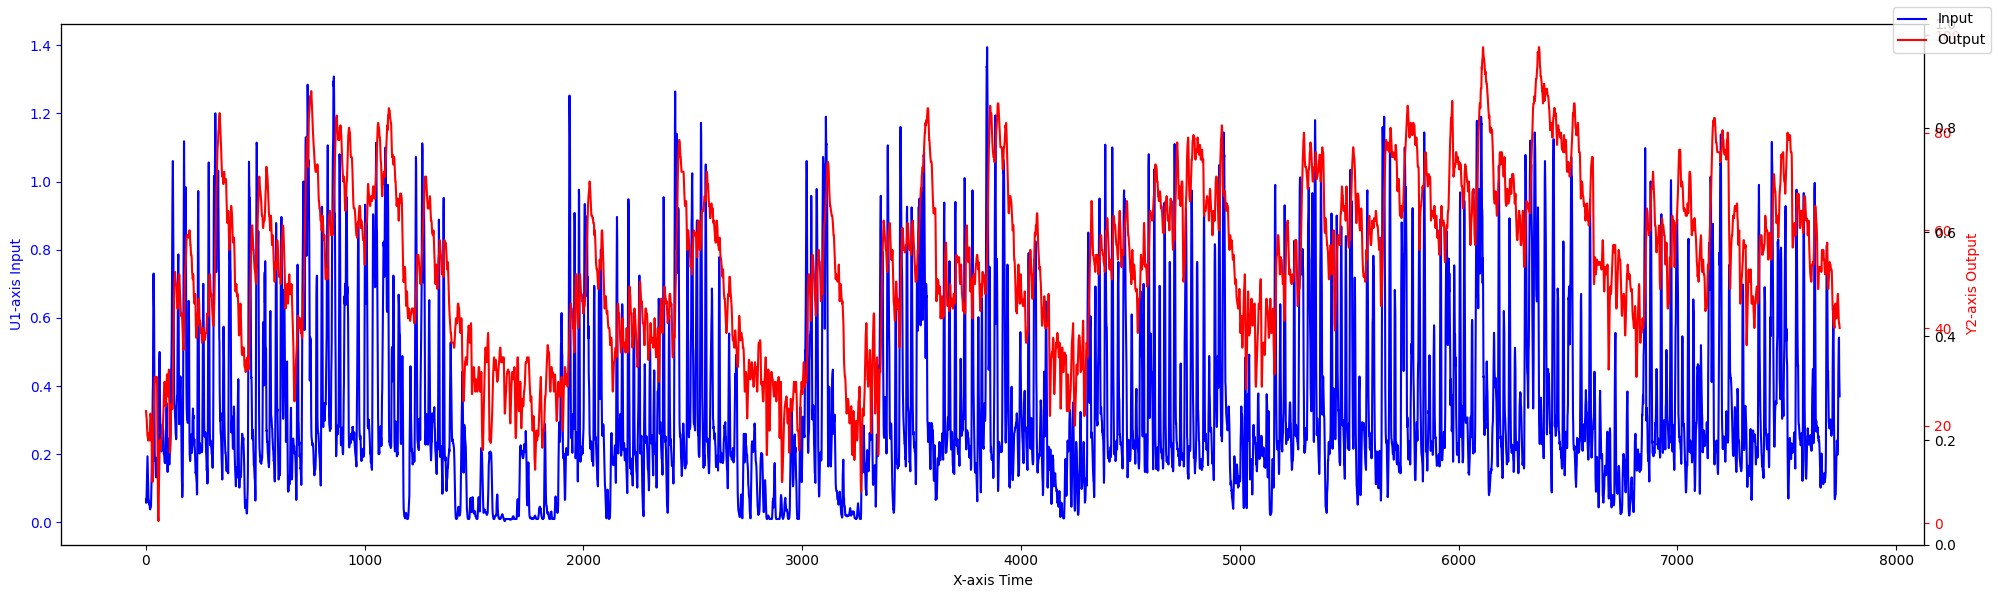

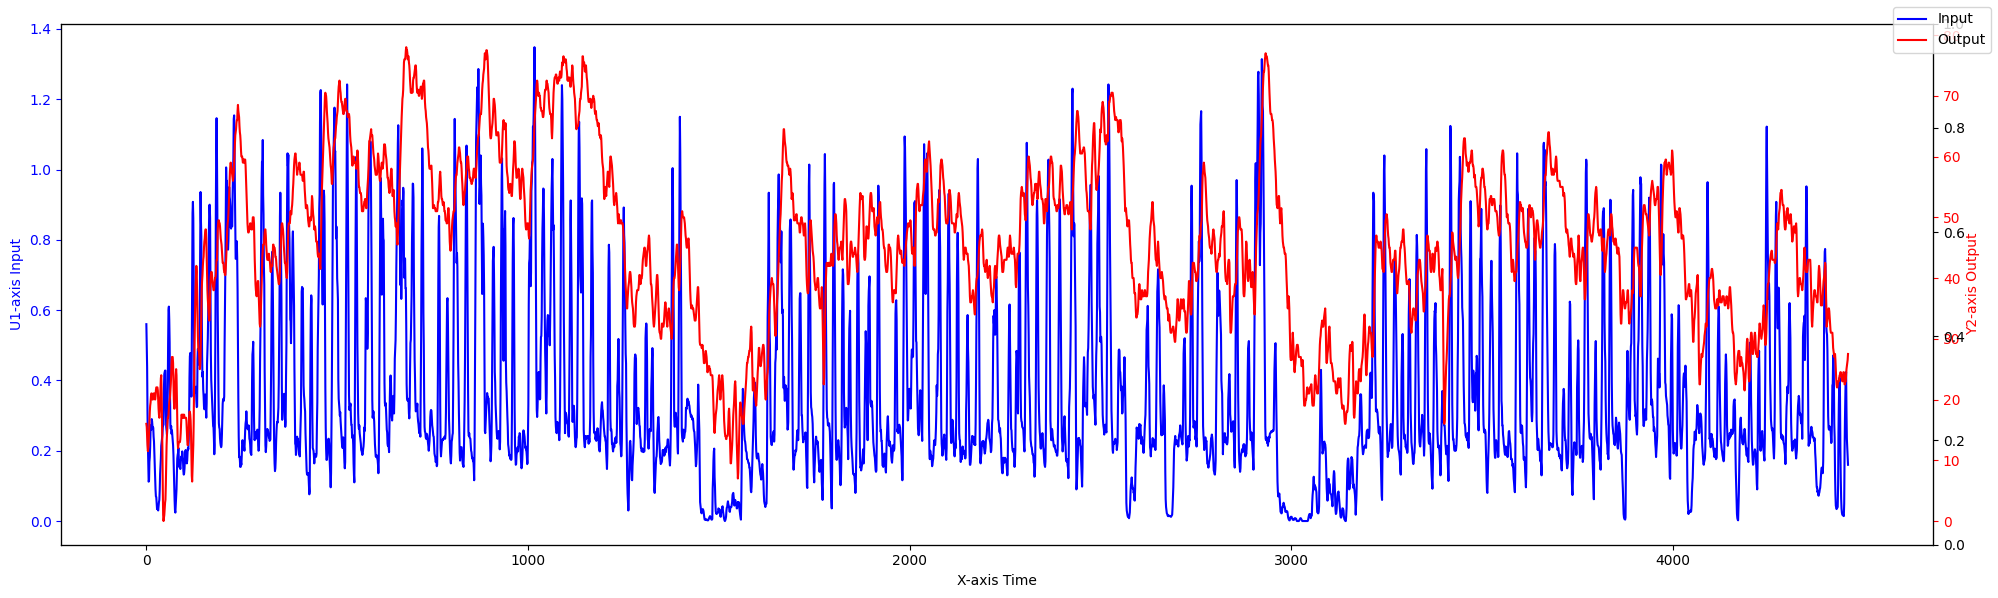

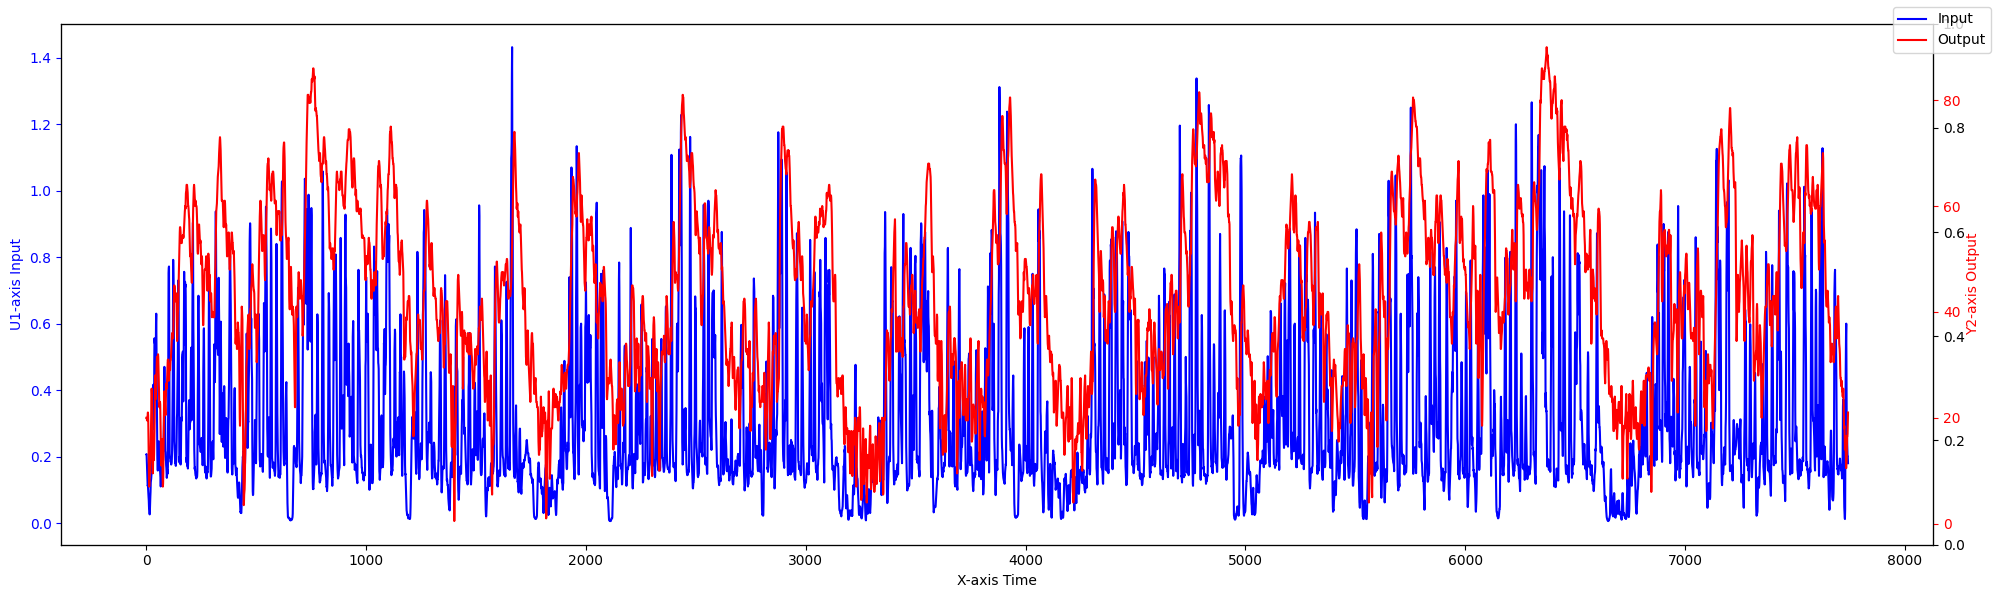

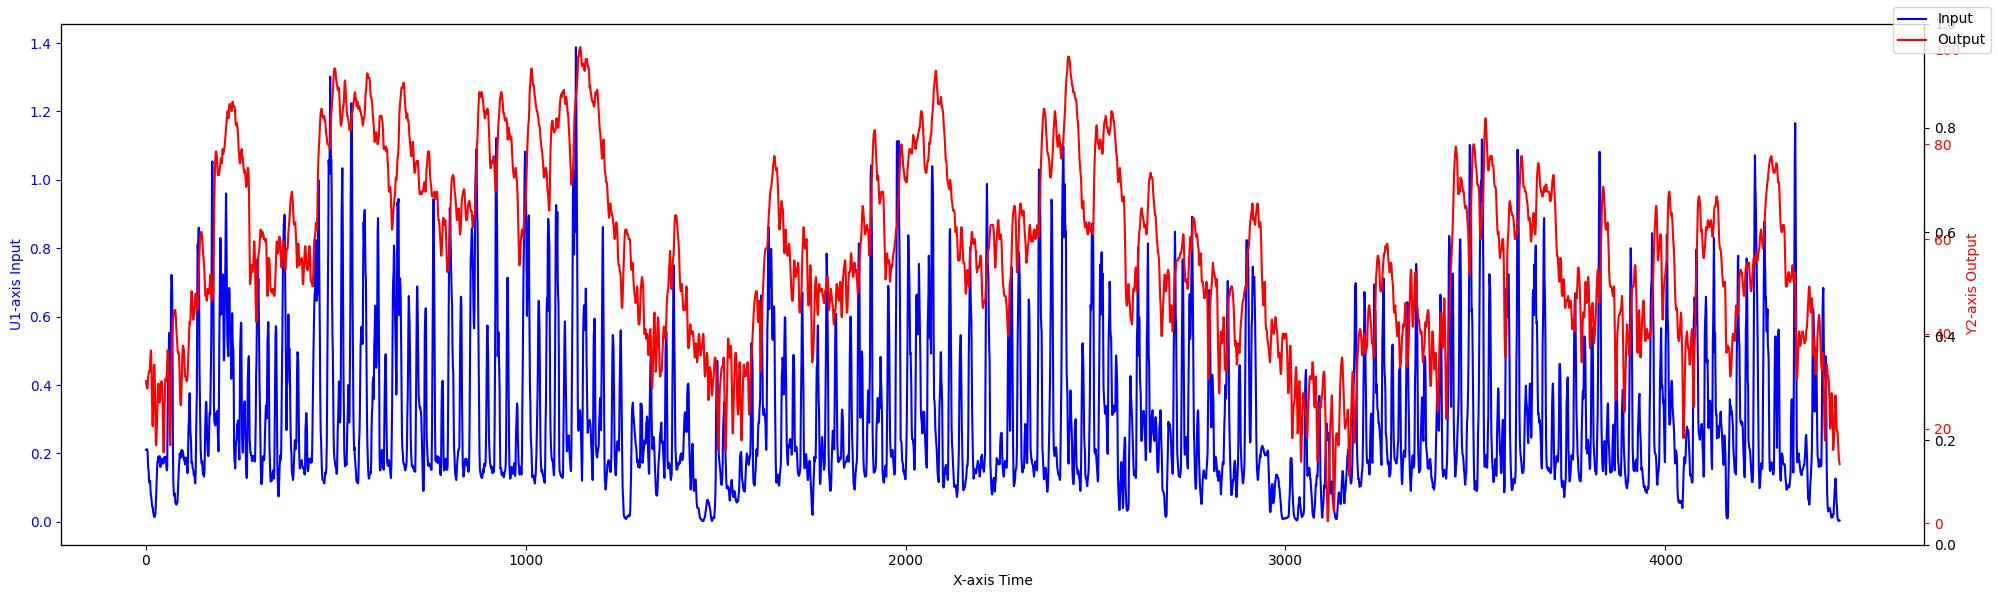

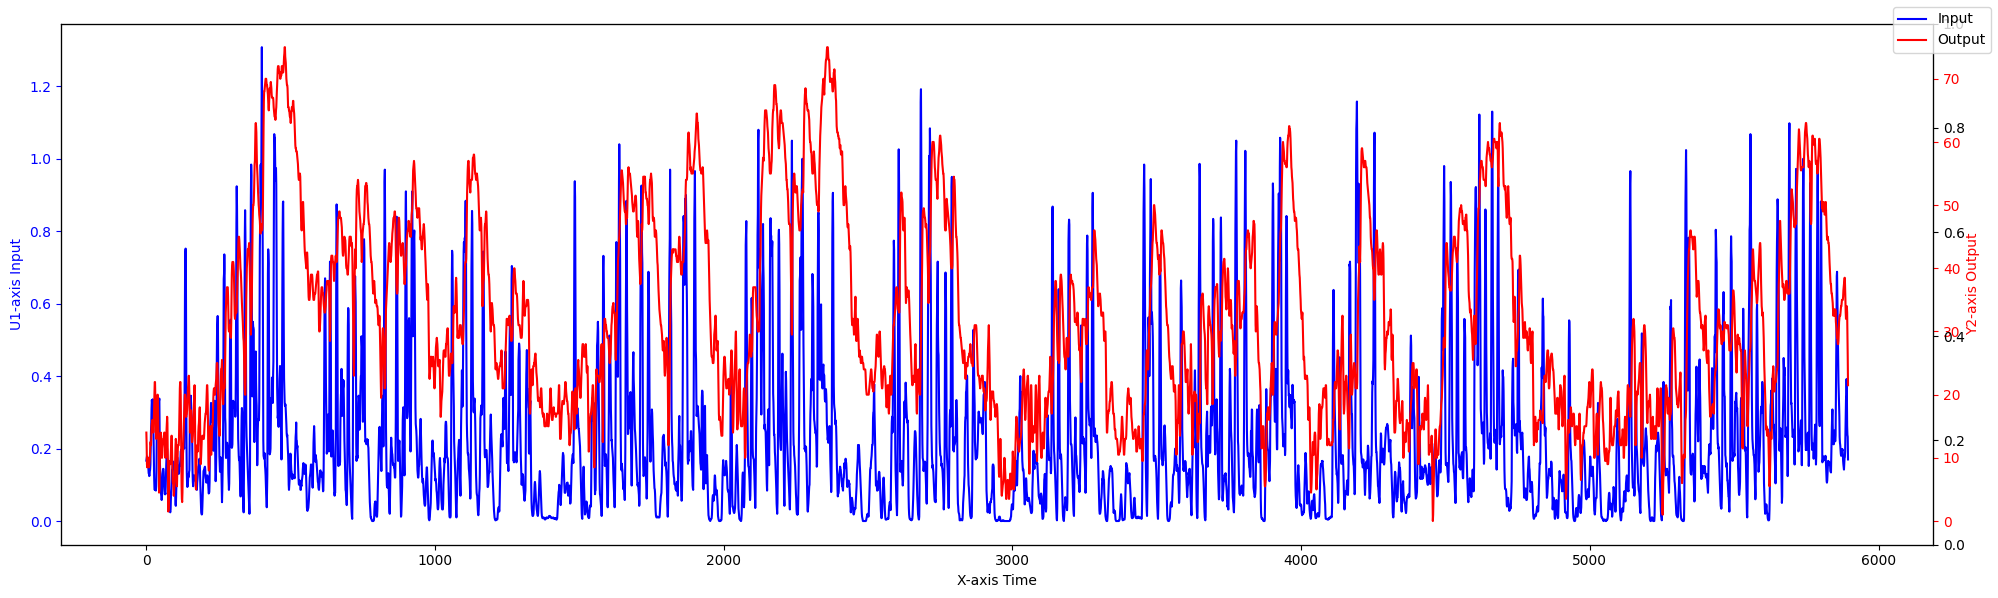

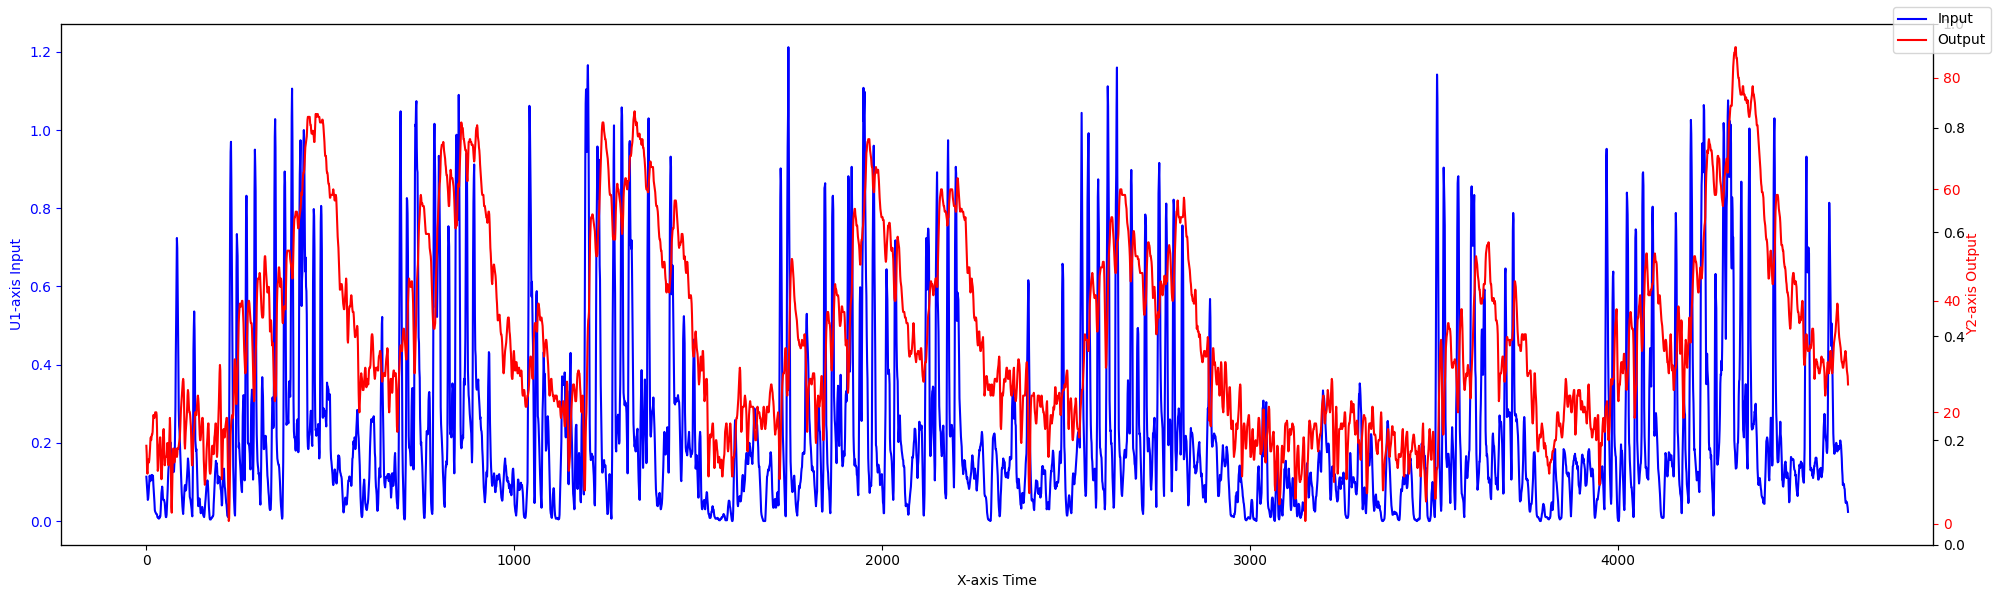

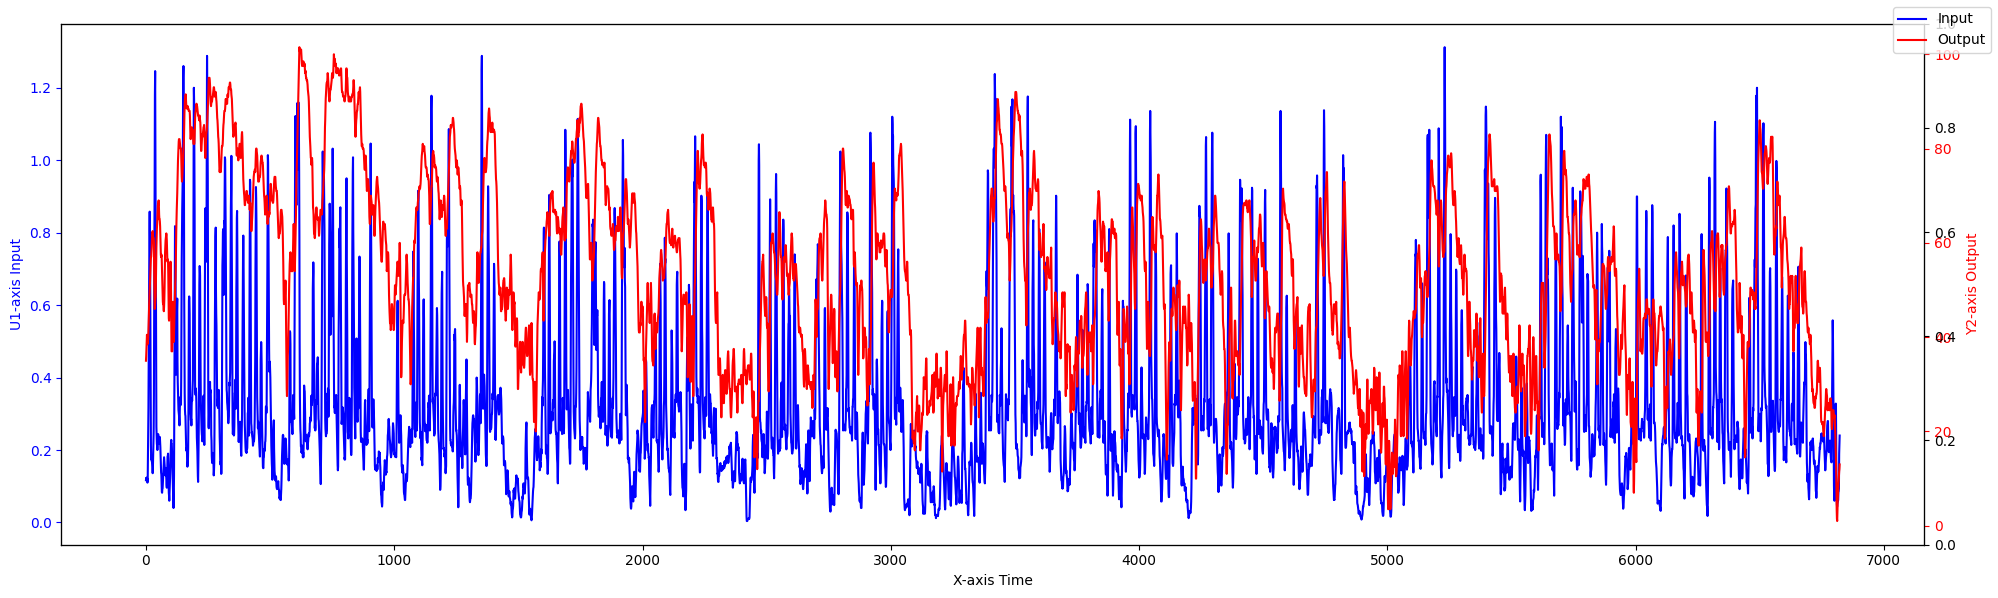

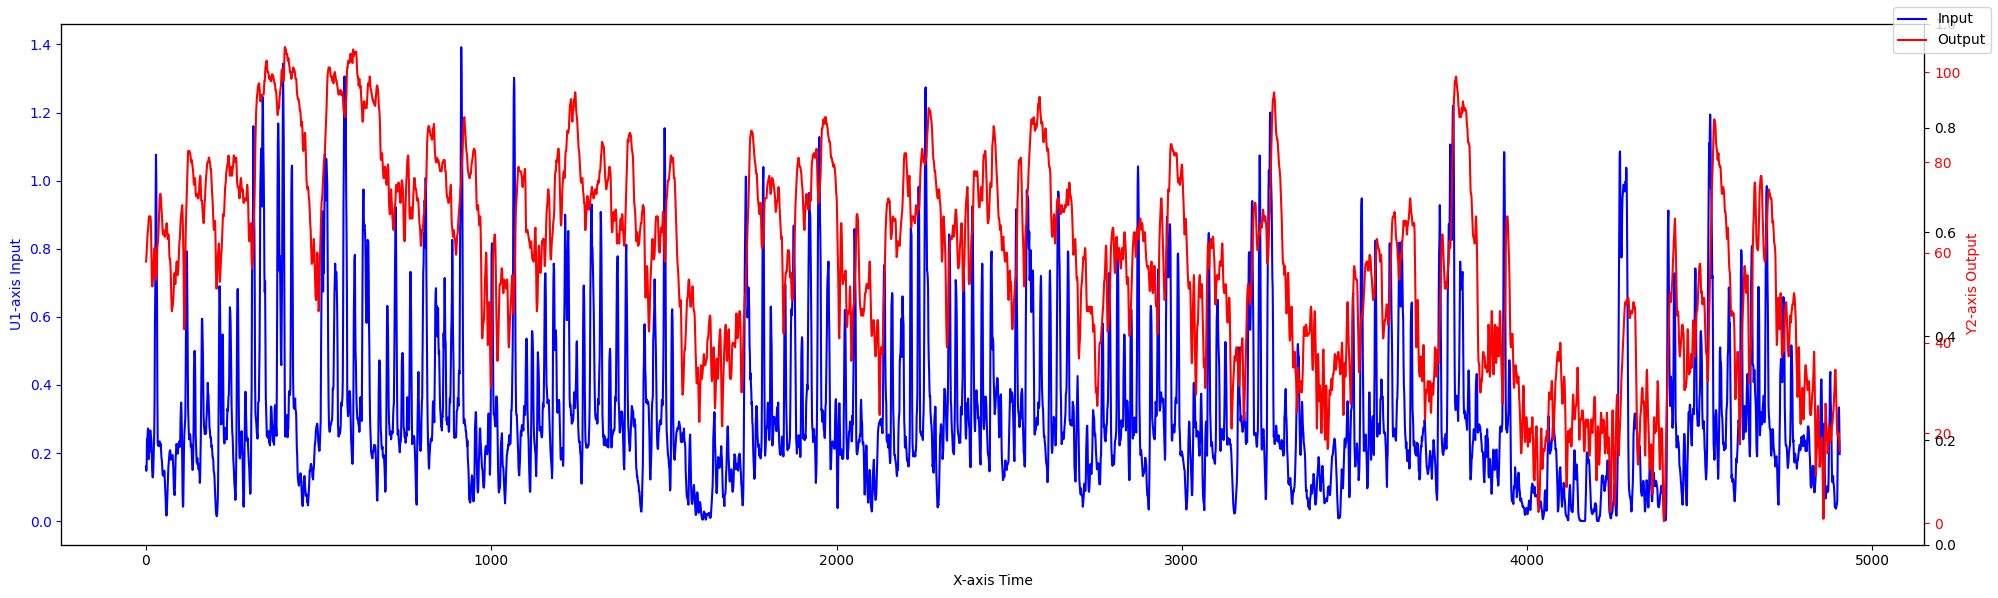

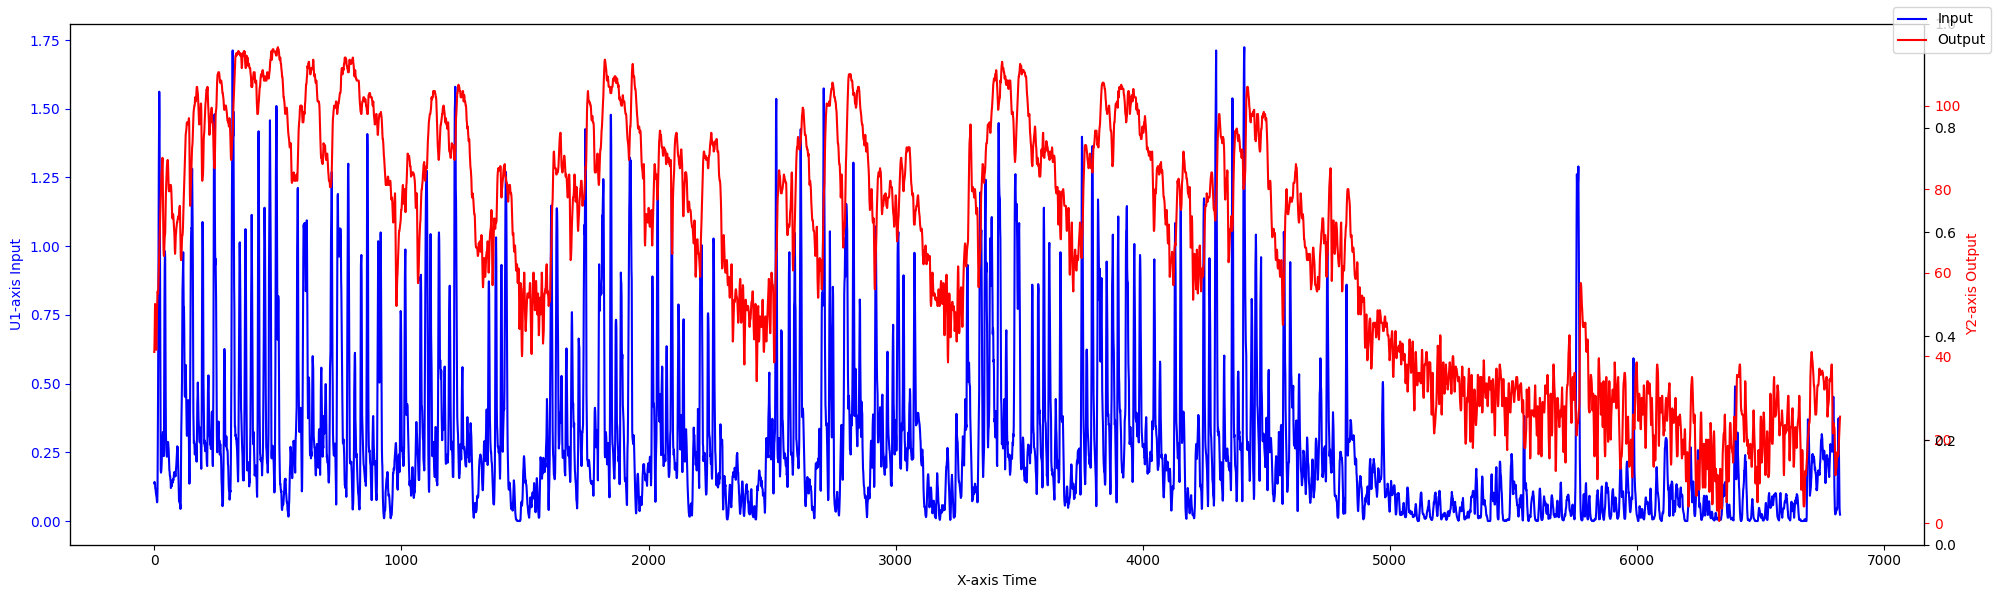

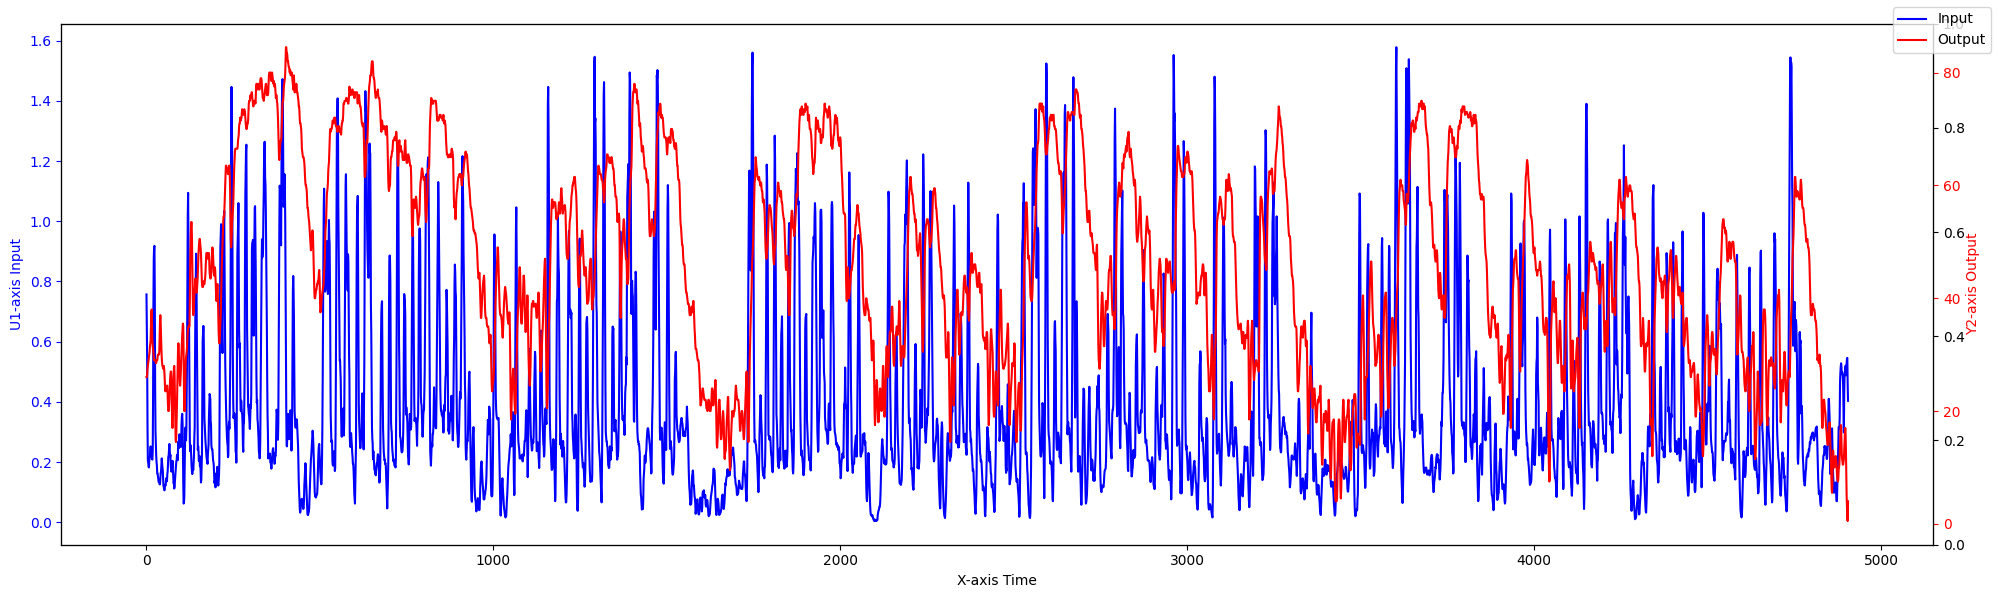

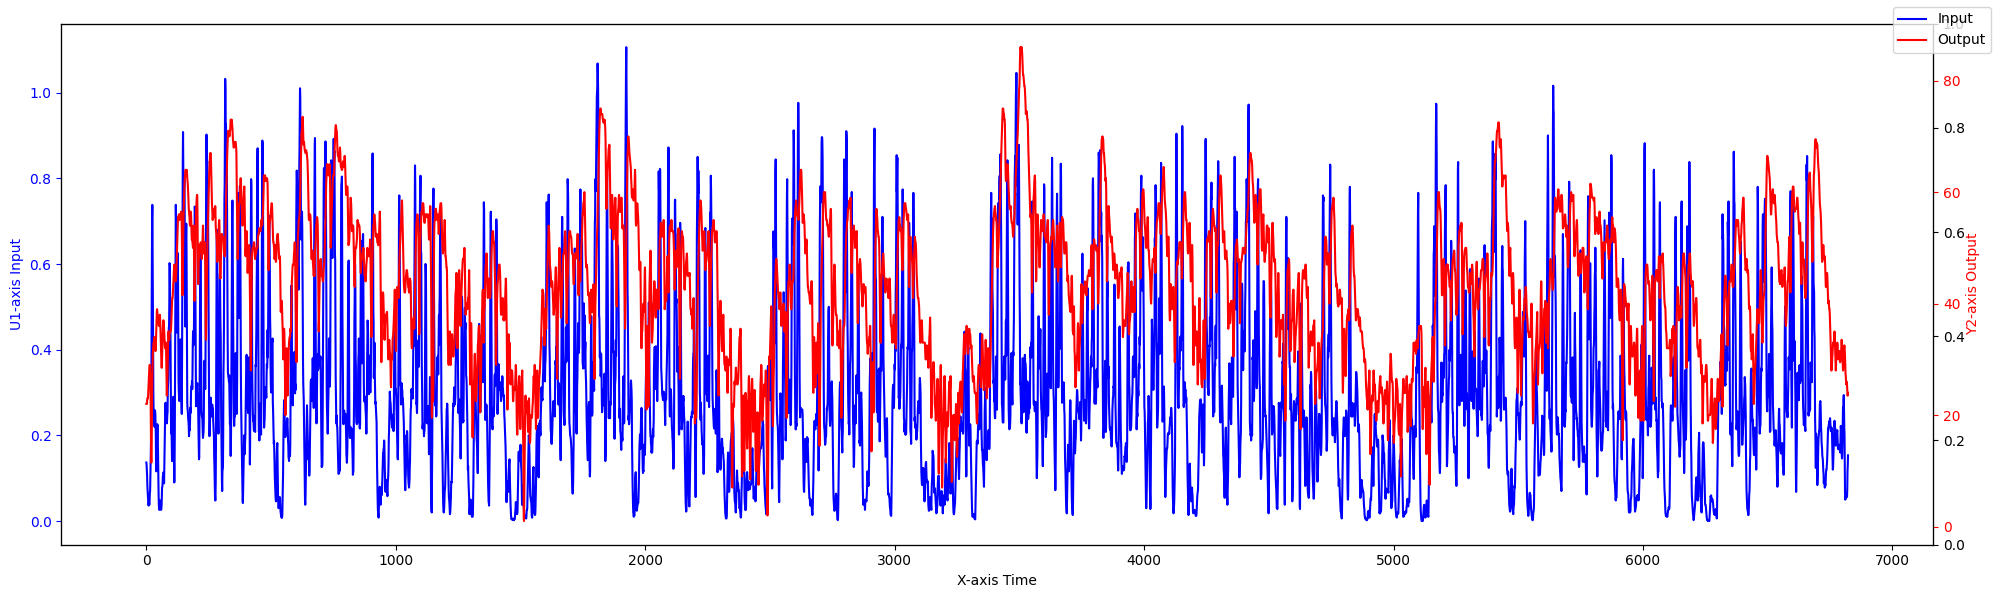

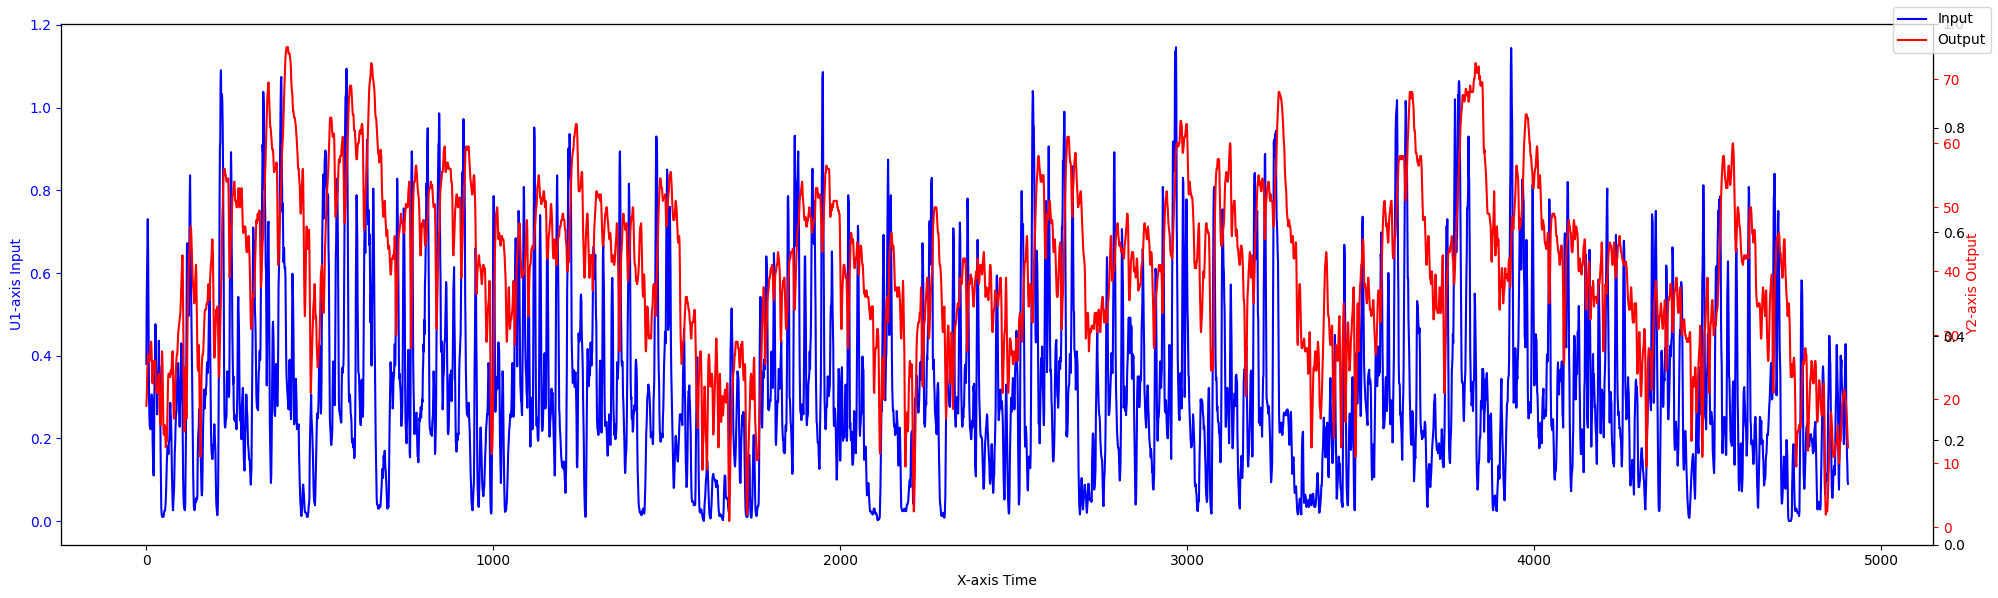

In [27]:
#1ºData Preparation
#Pre-processing && Ploting
limit = 0
for athlete in athlete_list:
  #Start all values at Zero
  vprint(f"Athlete:{athlete.shape}")
  #athlete['u'] = athlete['u'] - athlete['u'][0]
  #athlete['y'] = athlete['y'] - athlete['y'][0]

  athlete['u'] = athlete['u'] - athlete['u'].min()
  athlete['y'] = athlete['y'] - athlete['y'].min()

  athlete['u'] = athlete['u'].rolling(window=5, center=True, min_periods=1).mean()
  athlete['y'] = athlete['y'].rolling(window=2, center=True, min_periods=1).mean()


  #Ploting using two axis with different scales
  fig, ax1 = plt.subplots(figsize=(20, 6))
  ax1.plot(athlete['u'], color='blue', label='Input')
  ax1.set_xlabel('X-axis Time')
  ax1.set_ylabel('U1-axis Input', color='blue')
  ax1.tick_params('y', colors='blue')
  ax2 = ax1.twinx()
  vprint("athlete['u']",'Max:',athlete['u'].max(),'Min:',athlete['u'].min())
  vprint("athlete['y']",'Max:',athlete['y'].max(),'Min:',athlete['y'].min())

  #trend = mk.original_test(athlete['y'])
  ax3 = ax1.twinx()
  #ax3.plot(trend, color='green', label='Output')

  '''  if athlete.shape[0] == 7743 and limit == 0:
    print("tEAWDAWDrue")
    athlete_list[0]['u'] = athlete['u']
    athlete_list[0]['y'] = athlete['y']
    limit +=+ 1'''
  #y_mean = np.mean(athlete['y'])
  #print("Mean of y:", y_mean)
  #print("Variance of y:", np.var(y))
  ax2.plot(athlete['y'], color='red', label='Output')
  ax2.set_ylabel('Y2-axis Output', color='red')
  ax2.tick_params('y', colors='red')
  fig.legend(loc="upper right")
  fig.tight_layout()


In [ ]:
#Smoothing the Data
#capture important patterns in the data, while leaving out noise or other fine-scale structures/rapid phenomena.

## 2º System Identification

In [ ]:
from re import X

import matplotlib.pyplot as plt
import seaborn as sns


In [51]:
def models_find_best(na_min = 1, na_max = 3, nb_min = 0, nb_max = 2, d_min = 0, d_max = 2):
    '''
    Find the best model structure (time-invariant modelling)

    Parameters:
    na_min - minimum number of AR terms
    na_max - maximum number of AR terms
    nb_min - minimum number of MA terms
    nb_max - maximum number of MA terms
    d_min - minimum delay
    d_max - maximum delay
    showR2 - if True, show R-squared
    showAIC - if True, show AIC
    showRMSE - if True, show RMSE
    showFPE - if True, show FPE
    showBIC - if True, show BIC

    Return:
    results_df - dataframe with the results of the models

    '''

    # Find the best model structure (time-invariant modelling)
    results_df = pd.DataFrame(columns=['Athlete_Code','Model_Index', 'na', 'nb', 'd', 'AIC', 'Rsq','RMSE','BIC','FPE'])
    selected_models = pd.DataFrame(columns=['Athlete_Code','ParamCount','ParamValues','Metrics'])  #ParamCount[na:nb:d] || ParamValues[na,nb] || Metrics[Rsq, AIC, FPE]

    # Calculate ARX models to the evaluation data with all possible parameters to find the best fit by checking r-squared and AIC


    # Loop through athletes+games
    for i in range(len(athlete_list)):
        data = athlete_list[i]
        model_count=0
        vprint(f"Athlete: {code_name[i]}")
        ##Loop through parameters
        for na in range(na_min, na_max):
            for nb in range(nb_min+1,nb_max+1):
                for d in range(d_min, d_max+1):
                    vprint(f'>>> Model #{model_count} Dataset:{code_name[i]}, params: na={na}, nb={nb}, d={d}')

                    ##Calculate the a and b parameters
                    y_loader, ysim, parameters_a, parameters_b, SSG, tau, r_squared, aic, Rmse, bic, fpe = model_generator(data, na, nb, d)

                    vprint(f"its regression yield r squared: {r_squared}, Akaike's information criteria: {aic}")

                    # Save relevant information to the empty lists
                    new_row = pd.DataFrame({'Athlete_Code': code_name[i],'Model_Index': [model_count], 'na': [na], 'nb': [nb], 'd': [d], 'AIC': [aic], 'Rsq': [r_squared],'RMSE':[Rmse], 'BIC':[bic],'FPE':[fpe], 'Parameters_a':[parameters_a], 'Parameters_b':[parameters_b]})
                    results_df = pd.concat([results_df, new_row], ignore_index=True)

                    # Update the model counter
                    model_count += 1

    return results_df


In [52]:


def plot_line_models_results(results_df, plotmetrics=["Rsq", "AIC", "RMSE", "FPE", "BIC"]):

    #Plot for each player/game
    fig, ax1 = plt.subplots(figsize=(20, 6))
    X_axis = np.arange(len(results_df)) #results_df['Model_Index']

    if "Rsq" in plotmetrics:
        #For R-square Error
        ax1.plot(X_axis, results_df['Rsq'], color='blue', label='R-squared')
        ax1.set_xlabel('Model Index', fontsize=14)  # Increased font size
        ax1.set_ylabel('R-squared', color='blue', fontsize=14)  # Increased font size
        ax1.tick_params(axis='y', labelcolor='blue', labelsize=12)  # Increased tick label size

    if "AIC" in plotmetrics:
        #For AIC
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.plot(X_axis, results_df['AIC'], color='red', label='AIC')
        ax2.set_ylabel('AIC', color='red', fontsize=14)  # Increased font size
        ax2.tick_params(axis='y', labelcolor='red', labelsize=12)  # Increased tick label size

    if "RMSE" in plotmetrics:
        #For RMSE
        ax3 = ax1.twinx()
        ax3.plot(X_axis, results_df['RMSE'], color='green', label='RMSE', linestyle='--')
        ax3.set_ylabel('RMSE', color='green', fontsize=14)
        ax3.tick_params(axis='y', labelcolor='green', labelsize=12)

    if "FPE" in plotmetrics:
        #For FPE
        ax4 = ax1.twinx()
        ax4.plot(X_axis, results_df['FPE'], color='purple', label='FPE', linestyle=':')
        ax4.set_ylabel('RMSE', color='purple', fontsize=14)
        ax4.tick_params(axis='y', labelcolor='purple', labelsize=12)

    if "BIC" in plotmetrics:
        #For BIC
        #ax5 = ax4.twinx()
        ax5 = ax1.twinx()
        ax5.plot(X_axis, results_df['BIC'], color='orange', label='BIC', linestyle='-.')
        ax5.set_ylabel('BIC', color='orange', fontsize=14)
        ax5.tick_params(axis='y', labelcolor='orange', labelsize=12)

    # General graphic configs
    fig.legend(loc="upper right", fontsize=12)  # Add a legend for both plots, increased font size
    ax1.grid(True, linestyle='--', alpha=0.7)  # Added grid with dashed lines and transparency
    if "AIC" in plotmetrics:
        ax2.grid(True, linestyle='--', alpha=0.7)  # Added grid with dashed lines and transparency
    plt.title('Model Evaluation Metrics vs. Model Index', fontsize=16)  # Added title with increased font size
    plt.tight_layout()  # Adjust layout to prevent overlapping elements
    plt.show()



In [53]:
# prompt: Take results_df, represent the models for each athlete and game as a vertical boxplot

def plot_boxplot_models_results(results_df, plotmetrics=["Rsq", "AIC", "RMSE", "FPE", "BIC"]):
    """
    Generates a vertical boxplot per metric, representing the models for each athlete and game.

    Args:
    results_df: DataFrame containing model evaluation results.  Must have columns 'Athlete_Code', 'Model_Index', and the metric to plot (e.g., 'AIC', 'Rsq').
    """
    for metric in plotmetrics:
        plot_boxplot(results_df, metric)


def plot_boxplot(results_df, metric):

    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Athlete_Code', y=metric, data=results_df) # Replace 'AIC' with your desired metric column
    plt.xlabel("Athlete Code", fontsize=12)
    plt.ylabel(metric, fontsize=12) # Replace with your metric's name
    plt.title("Model Performance by Athlete", fontsize=14)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
    plt.tight_layout()
    plt.show()



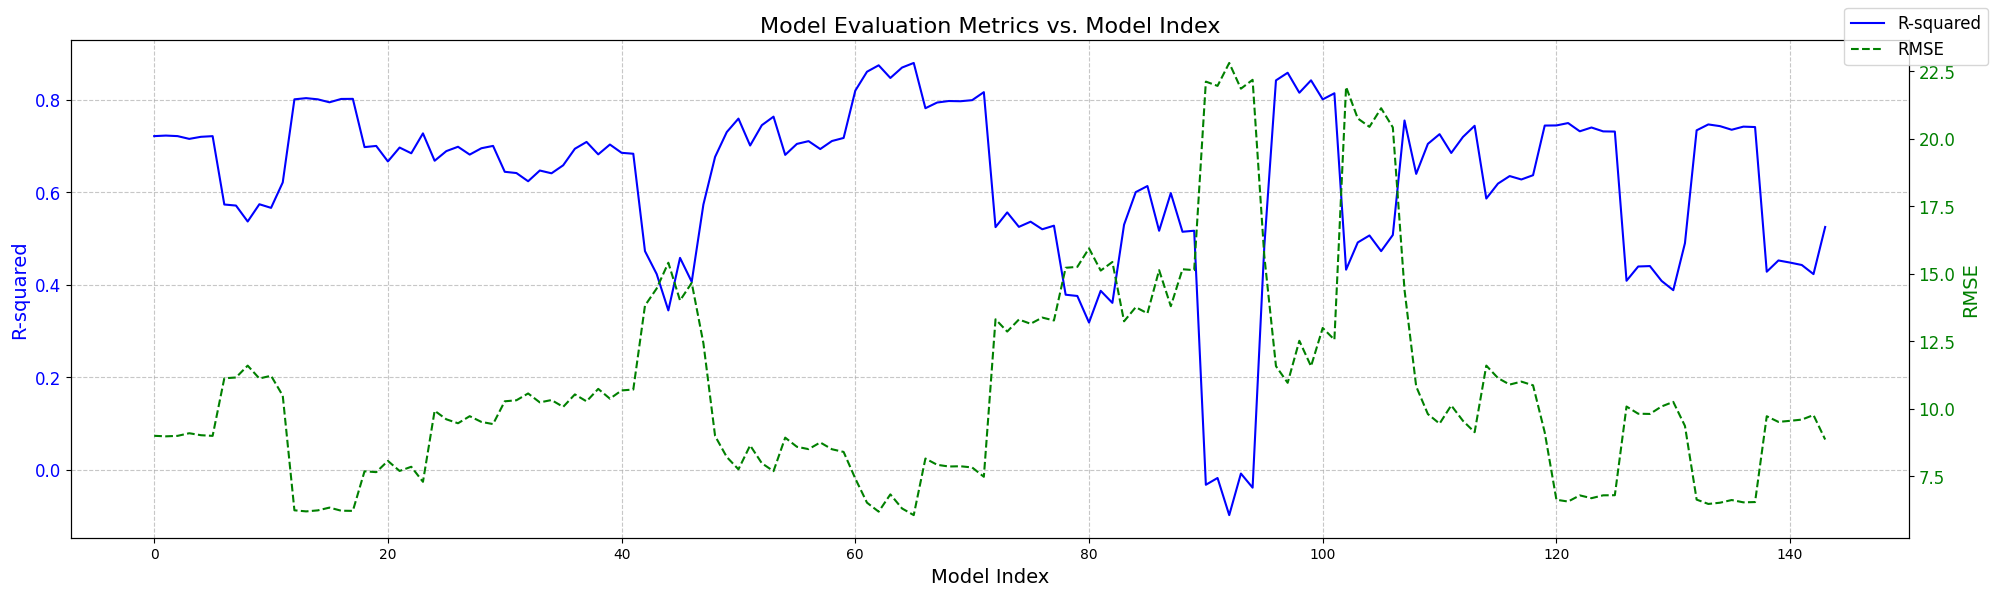

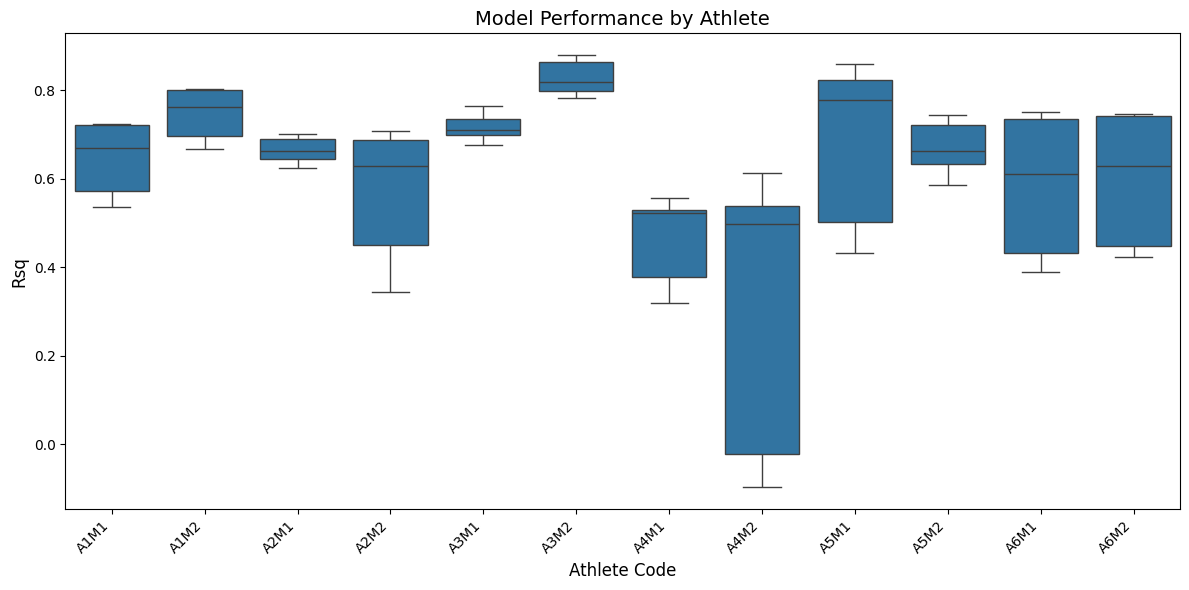

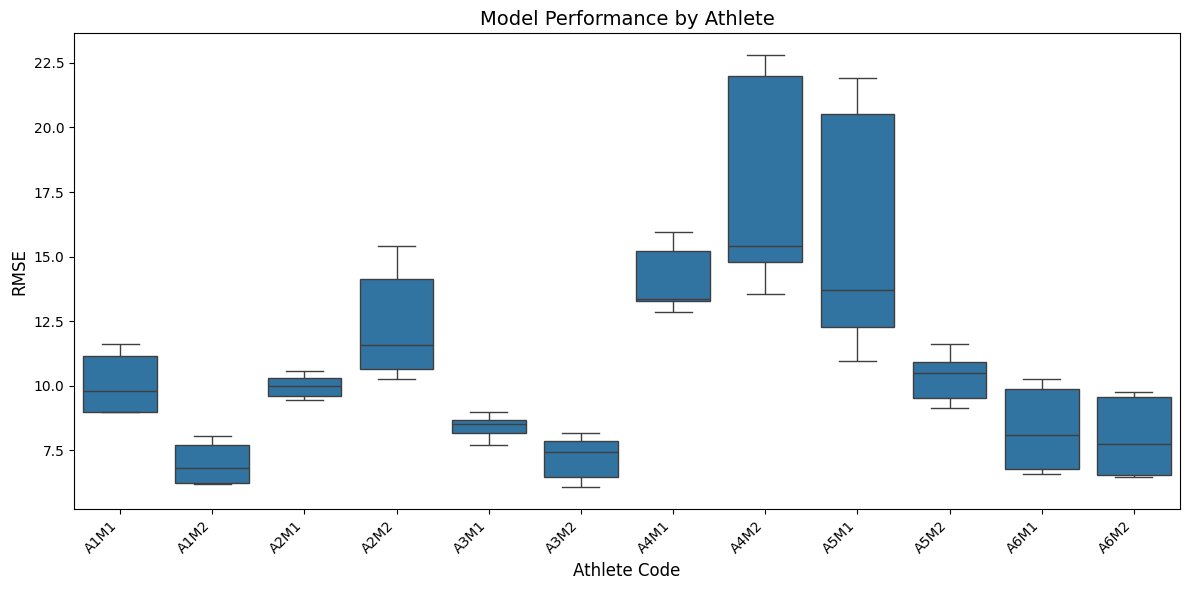

In [37]:

results_df = models_find_best(na_min = 1, na_max = 3, nb_min = 0, nb_max = 2, d_min = 0, d_max = 2)
plot_line_models_results(results_df, ["Rsq", "RMSE"])
plot_boxplot_models_results(results_df, ["Rsq", "RMSE"])


In [54]:
results_df = models_find_best(na_min = 1, na_max = 3, nb_min = 0, nb_max = 2, d_min = 0, d_max = 2)


Athlete: A1M1
>>> Model #0 Dataset:A1M1, params: na=1, nb=1, d=0
SSG: 160.1312281503803, SSG2: [160.13122815], SSG3: 2230573.433584416
its regression yield r squared: 0.721065334492146, Akaike's information criteria: -9880.812940940907
>>> Model #1 Dataset:A1M1, params: na=1, nb=1, d=1


<ipython-input-51-874dc413e09c>:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


SSG: 159.672824761986, SSG2: [159.67282476], SSG3: 2358630.835028478
its regression yield r squared: 0.7222589476800276, Akaike's information criteria: -9914.013481817623
>>> Model #2 Dataset:A1M1, params: na=1, nb=1, d=2
SSG: 158.8736008835684, SSG2: [158.87360088], SSG3: 2480037.5231559444
its regression yield r squared: 0.7210868482906734, Akaike's information criteria: -9880.133237603452
>>> Model #3 Dataset:A1M1, params: na=1, nb=2, d=0
SSG: 159.13285910523794, SSG2: [159.13285911], SSG3: 2334425.022668926
its regression yield r squared: 0.7151096460742289, Akaike's information criteria: -9715.249235328985
>>> Model #4 Dataset:A1M1, params: na=1, nb=2, d=1
SSG: 159.1360690487858, SSG2: [159.13606905], SSG3: 2494646.55738411
its regression yield r squared: 0.7195802615930538, Akaike's information criteria: -9836.431717678843
>>> Model #5 Dataset:A1M1, params: na=1, nb=2, d=2
SSG: 158.87127772526892, SSG2: [158.87127773], SSG3: 2479237.422090039
its regression yield r squared: 0.721

In [95]:
def plot_scatter_games_models(results_df, x="AIC", y="Rsq", groupby_athlete = True):
    # Group data by 'Athlete_Code'
    #grouped_data = results_df.groupby('Athlete_Code')
    if groupby_athlete:
        grouped_data = results_df.groupby('Athlete_Code')
    else:
        grouped_data = results_df.groupby(lambda x:0)

    # Iterate through each group and create a chart
    for athlete_code, group_df in grouped_data:
        vprint(athlete_code)
        plt.figure(figsize=(8, 6))  # Adjust figure size if needed
        for index, row in group_df.iterrows():
            legend_label = f"{row['na']}:{row['nb']}:{row['d']}"
            plt.scatter(row[x], row[y], label=legend_label, marker='o', s=50)  # Customize marker and size if desired
        plt.xlabel(x)
        plt.ylabel(y)
        plt.title(f'{y} vs {x} for {athlete_code}')
        if groupby_athlete:
            plt.legend(loc='best', fontsize='xx-small', ncol=3)  # Adjust legend location and font size if needed
        # else:
        #     plt.legend(loc='lower center', fontsize='xx-small', ncol=3)  # Adjust legend location and font size if needed
        plt.grid(True)
        plt.show()



0


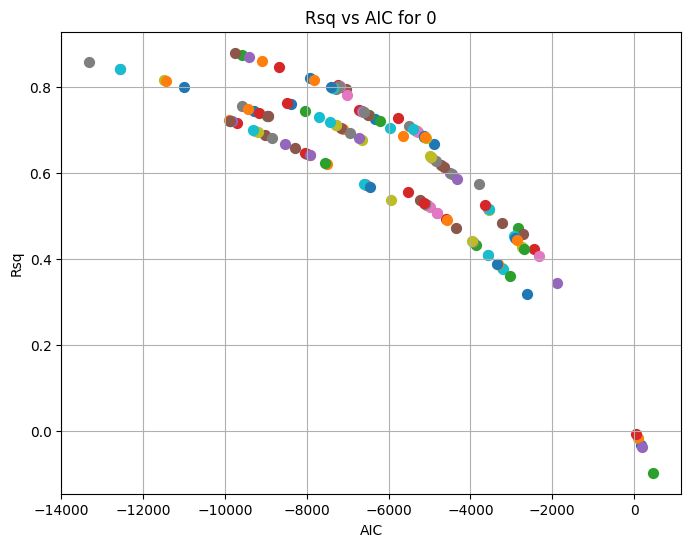

In [96]:
plot_scatter_games_models(results_df, x="AIC", y="Rsq", groupby_athlete=False)
#plot_scatter_games_models(results_df, x="RMSE", y="BIC")

In [50]:

results_df

Athlete_Code Model_Index na nb  d          AIC       Rsq       RMSE  \
0          A1M1           0  1  1  0 -9880.812941  0.721065   8.999236   
1          A1M1           1  1  1  1 -9914.013482  0.722259   8.979961   
2          A1M1           2  1  1  2 -9880.133238  0.721087   8.997535   
3          A1M1           3  1  2  0 -9715.249235  0.715110   9.094803   
4          A1M1           4  1  2  1 -9836.431718  0.719580   9.021803   
5          A1M1           5  1  2  2 -9875.139566  0.721025   8.997114   
6          A1M1           6  2  1  0 -6585.539239  0.573230  11.129765   
7          A1M1           7  2  1  1 -6544.619450  0.570968  11.159220   
8          A1M1           8  2  1  2 -5946.958111  0.536531  11.598429   
9          A1M1           9  2  2  0 -6594.501296  0.573834  11.121887   
10         A1M1          10  2  2  1 -6453.281879  0.565988  11.223800   
11         A1M1          11  2  2  2 -7500.375914  0.620945  10.487490   

             BIC           FPE                               Parameters_a  \
0   34038.420518  6.273196e+05                       [0.9887649264477053]   
1   34005.219977  6.246352e+05                       [0.9874089874928174]   
2   34031.097993  6.270014e+05                       [0.9868988037498277]   
3   34210.938639  6.408794e+05                       [0.9876154163467569]   
4   34081.753799  6.305512e+05                       [0.9868015021450772]   
5   34034.933977  6.270238e+05                       [0.9868925202826865]   
6   37332.646278  9.596340e+05  [1.7651126509790147, -0.7701818195824667]   
7   37373.566066  9.647202e+05   [1.7586404694366382, -0.763679102319999]   
8   37971.227405  1.042154e+06  [1.7609627374036732, -0.7654273705849552]   
9   37330.638506  9.585237e+05  [1.7640121261813773, -0.7691205670145851]   
10  37471.857924  9.761705e+05  [1.7669278886736095, -0.7715851909153741]   
11  36416.651786  8.521832e+05   [1.767095891612037, -0.7710489049264786]   

                                  Parameters_b  
0                         [1.7990861262888056]  
1                         [2.0104425336353478]  
2                         [2.0814342241471695]  
3      [-1.126512909557262, 3.097307115125834]  
4     [0.5424136030187765, 1.5579434629624656]  
5   [2.0651761374135282, 0.017225913034117468]  
6                         [0.7514032083686228]  
7                         [0.7427353766773199]  
8                         [0.6453350387393234]  
9    [0.6745149714743036, 0.08292914068412055]  
10   [1.4613692958240225, -0.7766057241428218]  
11    [1.681231628053003, -1.1124993428054974]

# ESTOU NESTA PARTE


In [ ]:
def best_models( normalize_data = False, na_min = 1, na_max = 3, nb_min = 0, nb_max = 2, d_min = 0, d_max = 2):

    #Select Best Models
    #scaler = MinMaxScaler()


    if normalize_data:
        #normalized_metrics = scaler.fit_transform(results_df[['AIC', 'Rsq', 'FPE', 'BIC', 'RMSE']])
        normalized_metrics = results_df.copy()

        # Create a new DataFrame with the normalized metrics
        normalized_df = pd.DataFrame(normalized_metrics, columns=['AIC_norm', 'Rsq_norm', 'FPE_norm', 'BIC_norm', 'RMSE_norm'])
        selection_df = pd.concat([results_df, normalized_df], axis=1)

    else:
        selection_df = results_df.copy()

    #best_models_df = pd.DataFrame(columns=['Athlete_Code','ParamCount','ParamValues','Metrics'])  #ParamCount[na:nb:d] || ParamValues[na,nb] || Metrics[Rsq, AIC, FPE]
    best_models_df = pd.DataFrame()


    num_models = na_max*nb_max*(xdelay_max+1)
    cases = len(results_df)/(num_models) #12

    #LOOP for each case (models)
    for i in range(int(cases)):
    print("Case: ",i,"Start: ",(i*num_models),"End: ",(i+1)*num_models)
    #Select each dataset models data
    selected_df = selection_df[(i*num_models):(i+1)*num_models].copy()

    #Create a Ranking Selection
    selected_df['AIC_rank'] = selected_df['AIC'].rank()
    selected_df['BIC_rank'] = selected_df['BIC'].rank()

    # Rank by Rsq
    selected_df['Rsq_rank'] = selected_df['Rsq'].rank(ascending=False)  # Note: ascending=False for Rsq

    # Calculate the combined ranking
    selected_df['Ranking'] = selected_df['Rsq_rank'] + selected_df['AIC_rank']+ selected_df['BIC_rank']

    best_df = selected_df.sort_values(by='Ranking', ascending=True).iloc[0]
    #new_row = pd.DataFrame({'Athlete_Code':[filter['Athlete_Code'][0]],'ParamCount'["{}:{}:{}".format(filter['na'][0],filter['nb'][0],filter['d'][0])],'ParamValues':[],'Metrics':[filter['Rsq'][0],filter['AIC'][0],filter['FPE'][0]]})

    #print(best_df)
    #print(selected_df.sort_values(by='Ranking', ascending=True))



    new_row = pd.DataFrame({'Athlete_Code': [best_df['Athlete_Code']],
                            'na': [best_df['na']],
                            'nb': [best_df['nb']],
                            'd': [best_df['d']],
                            'Ranking': [best_df['Ranking']],
                            'AIC_rank': [best_df['AIC_rank']],
                            'Rsq_rank': [best_df['Rsq_rank']],
                            'BIC_rank': [best_df['BIC_rank']],
                            'Rsq': [best_df['Rsq']],
                            'AIC': [best_df['AIC']],
                            'BIC': [best_df['BIC']],
                            'FPE': [best_df['FPE']],
                            'Parameters_a':[parameters_a],
                            'Parameters_b':[parameters_b]})

    best_models_df = pd.concat([best_models_df, new_row], ignore_index=True)
    return best_models_df

    #print(selected_df.sort_values(by='Rsq', ascending=False)[:3])
    #print(selected_df.sort_values(by='AIC', ascending=True)[:3])
    #print(selected_df.sort_values(by='FPE', ascending=True)[:3])


In [97]:


#Select Best Models
scaler = MinMaxScaler()
normalized_metrics = scaler.fit_transform(results_df[['AIC', 'Rsq', 'FPE', 'BIC', 'RMSE']])
# Create a new DataFrame with the normalized metrics
normalized_df = pd.DataFrame(normalized_metrics, columns=['AIC_norm', 'Rsq_norm', 'FPE_norm', 'BIC_norm', 'RMSE_norm'])
selection_df = pd.concat([results_df, normalized_df], axis=1)


#best_models_df = pd.DataFrame(columns=['Athlete_Code','ParamCount','ParamValues','Metrics'])  #ParamCount[na:nb:d] || ParamValues[na,nb] || Metrics[Rsq, AIC, FPE]
best_models_df = pd.DataFrame()


num_models = na_max*nb_max*(xdelay_max+1)
cases = len(results_df)/(num_models) #12

#LOOP for each case (models)
for i in range(int(cases)):
  print("Case: ",i,"Start: ",(i*num_models),"End: ",(i+1)*num_models)
  #Select each dataset models data
  selected_df = selection_df[(i*num_models):(i+1)*num_models].copy()

  #Create a Ranking Selection
  selected_df['AIC_rank'] = selected_df['AIC'].rank()
  selected_df['BIC_rank'] = selected_df['BIC'].rank()

  # Rank by Rsq
  selected_df['Rsq_rank'] = selected_df['Rsq'].rank(ascending=False)  # Note: ascending=False for Rsq

  # Calculate the combined ranking
  selected_df['Ranking'] = selected_df['Rsq_rank'] + selected_df['AIC_rank']+ selected_df['BIC_rank']

  best_df = selected_df.sort_values(by='Ranking', ascending=True).iloc[0]
  #new_row = pd.DataFrame({'Athlete_Code':[filter['Athlete_Code'][0]],'ParamCount'["{}:{}:{}".format(filter['na'][0],filter['nb'][0],filter['d'][0])],'ParamValues':[],'Metrics':[filter['Rsq'][0],filter['AIC'][0],filter['FPE'][0]]})

  #print(best_df)
  #print(selected_df.sort_values(by='Ranking', ascending=True))



  new_row = pd.DataFrame({'Athlete_Code': [best_df['Athlete_Code']],
                          'na': [best_df['na']],
                          'nb': [best_df['nb']],
                          'd': [best_df['d']],
                          'Ranking': [best_df['Ranking']],
                          'AIC_rank': [best_df['AIC_rank']],
                          'Rsq_rank': [best_df['Rsq_rank']],
                          'BIC_rank': [best_df['BIC_rank']],
                          'Rsq': [best_df['Rsq']],
                          'AIC': [best_df['AIC']],
                          'BIC': [best_df['BIC']],
                          'FPE': [best_df['FPE']],
                          'Parameters_a':[parameters_a],
                          'Parameters_b':[parameters_b]})

  best_models_df = pd.concat([best_models_df, new_row], ignore_index=True)

  #print(selected_df.sort_values(by='Rsq', ascending=False)[:3])
  #print(selected_df.sort_values(by='AIC', ascending=True)[:3])
  #print(selected_df.sort_values(by='FPE', ascending=True)[:3])


SyntaxError: 'return' outside function (<ipython-input-97-9d78d47a10d9>, line 56)

In [ ]:
best_models_df

In [ ]:
results_df.sort_values(by='Rsq', ascending=False)
#Rsq: 1,5,0,16,11,6,15,10,61
#AIC: 1,5,0,6,11,16,15,10,61
#FPE: 0,5,1,60,72,71,62,75,76

In [ ]:
#Simulation best model structure
number_a=1
number_b=2
d=0

data = athlete_list[2]
# print the relative dataframe and check its columns
y_loader, y_auto, parameters_a, parameters_b, SSG, tau, r_squared, aic, Rmse, bic, fpe = model_generator(data, number_a, number_b, d)


'''y = np.zeros(len(data))
y_auto = np.zeros(len(data))
y_auto[:max(number_a,number_b+d)] = data['y'][0]
#works for (0,1,0),(1,0,0)
for k in range(max(number_a,number_b +d), len(X_loader)):
  ##AUTOMATIC
  # Add the contribution from autoregressive terms (endogenous variables)
  for i_a in range(1, number_a + 1):
      y_auto[k] += den[i_a-1] * y_auto[k - i_a]  # Note: parameters_a starts at index 0
  # Add the contribution from exogenous input terms (with delay d)
  for j_b in range(number_b):
    #print("Input: ",'u-{}'.format(j_b+d))
    y_auto[k] += num[j_b] * X_loader['u-{}'.format(j_b+d)].iloc[k-j_b-d]'''



#Ploting
plt.figure(figsize=(20, 6))
X_axis = np.arange(0,y_loader.shape[0])
print(X_axis)
# Plot the actual values (y_loader)
plt.plot(data['y'], label='Real Value (y_loader)', color='blue')
plt.plot(data['u'], label='Real Input (y_loader)', color='purple', linestyle=':')
# Plot the original data (y)    *AUTOMATIC
plt.plot(X_axis, y_auto, label='Predicted Automatic (y_auto)', color='red', linestyle='--')

# Add labels and title
plt.xlabel('Time / Index')
plt.ylabel('Values')
plt.title('Comparison of Real data (y_loader) and Model Prediction (y_auto)')
plt.legend()  # Add a legend
plt.grid(True) # Add grid lines for better readability
# Adjust the y-axis limits if necessary for better visualization
#plt.ylim([50, 200])
plt.show()

In [ ]:
#Select one model and applie to all the datasets
number_a=1
number_b=2
d=0
one_4_all = pd.DataFrame(columns=['Athlete_Code', 'na', 'nb', 'd','SSG','TC' ,'AIC', 'Rsq','RMSE','BIC','FPE'])
model_count=0

for i in range(len(athlete_list)):
  data = athlete_list[i]
  print(f"Athlete: {code_name[i]}")
  print('\nModel #{} \nwith {} a parameters, {} b parameters and {} time delay'.format(model_count,number_a,number_b,d))
  #load the associated data using dataloader(data, na, nb, d)

  y_loader, y_auto, parameters_a, parameters_b, SSG, tau, r_squared, aic, Rmse, bic, fpe = model_generator(data, number_a, number_b, d)



  new_row = pd.DataFrame({'Athlete_Code': code_name[i],'SSG':[SSG],'TC':[tau], 'Parameters_a':[parameters_a], 'Parameters_b':[parameters_b], 'na': [number_a], 'nb': [number_b], 'd': [d], 'AIC': [aic], 'Rsq': [r_squared],'RMSE':[Rmse], 'BIC':[bic],'FPE':[fpe]})

  one_4_all = pd.concat([one_4_all, new_row], ignore_index=True)



  print("its regression yield r squared: {}, Akaike's information criteria: {}".format(r_squared, aic))

  # Save relevant information to the empty lists
  #new_row = pd.DataFrame({'Athlete_Code': code_name[i],'Model_Index': [model_count], 'na': [na], 'nb': [nb], 'd': [d], 'AIC': [aic], 'Rsq': [r_squared],'RMSE':[Rmse], 'BIC':[bic],'FPE':[fpe]})
  #results_df = pd.concat([results_df, new_row], ignore_index=True)
        # Update the model counter
  model_count += 1



#Do the parameter estimates vary a lot between the subjects or between the volleyball matches?



In [ ]:
one_4_all

In [ ]:
#Do the parameter estimates vary a lot between the subjects or between the volleyball matches?
athlete_codes = one_4_all['Athlete_Code'].to_list()

#Plot for each player/game
fig, ax1 = plt.subplots(figsize=(20, 6))
X_axis = athlete_codes #results_df['Model_Index']

#plot parameters A
ax1.plot(X_axis, one_4_all['Parameters_a'].str[0].tolist(), color='blue', label='A1')
#ax1.plot(X_axis, one_4_all['Param_a'].str[1].tolist(), color='blue', label='A2')
#ax1.plot(X_axis, one_4_all['Param_a'].str[2].tolist(), color='blue', label='A3')
ax1.set_xlabel('Athlete Code', fontsize=14)  # Increased font size
ax1.set_ylabel('Value', fontsize=14)  # Increased font size
ax1.tick_params(axis='y', labelcolor='blue', labelsize=12)  # Increased tick label size

#Plot parameters B
ax1.plot(X_axis, one_4_all['Parameters_b'].str[0].tolist(), color='red', label='B0')
ax1.plot(X_axis, one_4_all['Parameters_b'].str[1].tolist(), color='orange', label='B1')
#ax1.plot(X_axis, one_4_all['Param_b'].str[2].tolist(), color='red', label='B2')

'''#First param B
x2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(X_axis, one_4_all['Param_b'].str[0].tolist(), color='red', label='AIC')
#ax2.plot(X_axis, one_4_all['Param_b'].str[1].tolist(), color='red', label='AIC')
ax2.set_ylabel('Param_b', color='red', fontsize=14)  # Increased font size
ax2.tick_params(axis='y', labelcolor='red', labelsize=12)  # Increased tick label size
'''


# General graphic configs
fig.legend(loc="upper right", fontsize=12)  # Add a legend for both plots, increased font size
ax1.grid(True, linestyle='--', alpha=0.7)  # Added grid with dashed lines and transparency
ax2.grid(True, linestyle='--', alpha=0.7)  # Added grid with dashed lines and transparency
plt.title('Model Parameters for each dataset', fontsize=16)  # Added title with increased font size
plt.tight_layout()  # Adjust layout to prevent overlapping elements
plt.show()


In [ ]:
one_4_all

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the 'b' parameter values and athlete codes
b_values = one_4_all['Parameters_b'].to_list()
athlete_codes = one_4_all['Athlete_Code'].to_list()

num_athletes = len(athlete_codes)
num_params = len(b_values[0])  # Assuming all athletes have the same number of 'b' parameters

# Create an array to store the parameter values for each position
param_positions = [[] for _ in range(num_params)]
for athlete_params in b_values:
    for i, param_value in enumerate(athlete_params):
        param_positions[i].append(param_value)

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed

for i, position_values in enumerate(param_positions):
    plt.plot(athlete_codes, position_values, label=f"Position {i}")

# Customize the plot
plt.xlabel("Athlete Code")
plt.ylabel("Parameter Value")
plt.title("B parameter comparison by position")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.show()

In [ ]:
best_models_df

In [ ]:
one_4_all

In [ ]:
# Biological interpretation

#First Order Model
##
#  Code Here
##


#Second Order Model
##
#  Code Here
##




#Athlete Average Moder
#structure: 1:2:0
#for p_case in best_models_df.iterrows():
counter = 0
number_a=1
number_b=2
d=0
athlete_mean_model = pd.DataFrame(columns=['Athlete', 'Parameters_a', 'Parameters_b', 'Rsq_M1', 'AIC_M1', 'Rsq_M2', 'AIC_M2'])

for pcase in one_4_all.iterrows():
  #print(pcase)

  if pcase[1]["Athlete_Code"][3] == '1':    #First Game
    params_a_memory = pcase[1]['Parameters_a']
    params_b_memory = pcase[1]['Parameters_b']
    counter += 1

  else: #second game
    mean_a = (params_a_memory + pcase[1]['Parameters_a']) / 2
    mean_b = (params_b_memory + pcase[1]['Parameters_b']) / 2

    #Simulation
    #Simulation for first Game
    y_loader, ysim, parameters_a, parameters_b, SSG, tau, r_squared1, aic1, Rmse1, bic1, fpe1 = model_generator(athlete_list[counter-1], number_a, number_b, d)

    ## Simulate values of Y
    #Plot Simulation
    print("Game1:",r_squared1)
    plt.plot(y_loader, label='Real Value (y_loader)', color='blue')
    plt.plot(np.arange(len(ysim)), ysim, label='Predicted Mean (ysim)', color='red', linestyle='--')
    plt.xlabel('Time / Index')
    plt.ylabel('Values')
    plt.title('Athlete:{}  Game: 1 '.format(pcase[1]['Athlete_Code'][:2]))
    plt.legend()  # Add a legend
    plt.grid(True) # Add grid lines for better readability
    plt.show()


      ##Simulation for Second Game
    X_loader, y_loader = dataloader(athlete_list[counter], number_a, number_b, d)
    y_loader, ysim, parameters_a, parameters_b, SSG, tau, r_squared2, aic2, Rmse2, bic2, fpe2 = model_generator(athlete_list[counter], number_a, number_b, d)

    #Plot Simulation
    print("Game2:",r_squared2)
    plt.plot(y_loader, label='Real Value (y_loader)', color='green')
    plt.plot(np.arange(len(ysim)), ysim, label='Predicted Mean (ysim)', color='orange', linestyle='--')
    plt.xlabel('Time / Index')
    plt.ylabel('Values')
    plt.title('Athlete:{}  Game: 2 '.format(pcase[1]['Athlete_Code'][:2]))
    plt.legend()  # Add a legend
    plt.grid(True) # Add grid lines for better readability
    plt.show()


    #Save to the Dataframe
    new_row = pd.DataFrame({'Athlete': [pcase[1]['Athlete_Code'][:2]],'Parameters_a':[mean_a], 'Parameters_b':[mean_b], 'Rsq_M1':[r_squared1], 'AIC_M1':[aic1], 'Rsq_M2':[r_squared2], 'AIC_M2':[aic2]})
    athlete_mean_model = pd.concat([athlete_mean_model, new_row], ignore_index=True)
    plt.show()







In [ ]:
athlete_mean_model

 # Time-varying dynamics

In [ ]:
na = 2
nb = 1
d = 1

#INCORPORATE ASSIGNMENT DATA
X_loader, y_loader = dataloader(athlete_list[1], na, nb, d)
N = len(y_loader)
y = y_loader#.values.reshape(-1,1)
u = X_loader['u-{}'.format(d)].values.reshape(-1,1)

N = len(y_loader)
t = np.arange(N)                                        # example for 'time'/points 0-(N-1)
f = 2 * np.pi / 40                                      # f = chosen frequence for square wave


e = np.random.randn(N, 1) * np.sqrt(0.16)               # Noise vector e-N(0,0.16), 'standard normal distribution'is mean 0, standard deviation 1.
a1 = np.ones((N,1)) * -1                                # a1 = constant
a2 = np.ones((N,1)) * 0.25                              # a2 = constant (if you have a2 means it is second order system)
b0 = np.ones((N,1))
b0[200:899] = 2                                         # b0 = variable
# delay = 1


y = np.zeros((N,1))                                     # start with an empty vector for y
for k in range(max(na, nb+d-1), N):
    y[k] = -a1[k] * y[k-1] - a2[k] * y[k-2] + b0[k] * u[k-d] + e[k]  # if we have a2 means it is a second order system.

plt.plot(u)
plt.show()
plt.plot(y)

In [ ]:
# Time-variant - recursive ARX

dm = 3                              # Number of parameters to estimate
# Initialise matrix
X = np.zeros((dm,1))              # prepare an input matrix that can be used in the loop, size is the number of parameters
P = 1000 * np.eye(dm)            # Covariance matrix set to large value because of uncertainty at the beginning due to lack of measurement
a_hat = np.ones((dm,1))         # Minimum value to not create error in case of 0 division


# Information to be stored in the loop
a1est = np.zeros((N,1))
a2est = np.zeros((N,1))
b0est = np.zeros((N,1))


# Loop over all the data
for k in range(max(na, nb+d-1), N):
    # 1. Update the matrix X with the new data
    X[0] = - y[k-1]
    X[1] = - y[k-2]
    X[2] = u[k-d]

    # 2. Update gain matrix g
    g = (P @ X) / (1 +( X.T @ P @ X))

    # 3. Update covariance matrix P
    P = P - g @ X.T @ P

    # 4. Re-estimate the parameter coefficients
    yhat =  X.T @ a_hat      # y = data vector * parameters vetor
    error = y[k] - yhat
    a_hat = a_hat + g * error
    # OR: a_hat = a_hat + g * ( y(k) - (X' * a_hat))

    # 5. Store estimates (get the diagonal elements of a_hat that correspond to a1, a2, b0)
    a1est[k] = a_hat[0]
    a2est[k] = a_hat[1]
    b0est[k] = a_hat[2]

# Simulate model (step 2)
ysim2 = np.zeros((N,1))
for k in range(max(na, nb+d-1), N):
    ysim2[k] = - a1est[k] * ysim2[k-1] - a2est[k] * ysim2[k-2] + b0est[k] * u[k-d]

plt.plot(a1est)
plt.plot(a2est)
plt.plot(b0est)

plt.plot(a1)
plt.plot(a2)
plt.plot(b0)
plt.legend()
plt.show()

plt.plot(y)
plt.plot(ysim2)

print('R2:',r_2(y, ysim2))


In [ ]:
#Time-variant - recursive ARX RDW (rectancular data weighing)
Win = 500;                  # window size
# Initialise matrix
X_add = np.zeros((dm,1))
X_remove = np.zeros((dm,1))
P = 1000 * np.eye(dm)             # Covariance matrix set to large value because of uncertainty at the beginning due to lack of measurement
A_hat = np.ones((dm,1))           # Minimum value to don't create error in case of 0 division
# Information to be stored in the loop
a1est = np.zeros((N,1))
a2est = np.zeros((N,1))
b0est = np.zeros((N,1))

for k in range(max(na, nb+d-1), N):
    # 1. Update the matrix X with the new data
    X_add[0] = -y[k-1]
    X_add[1] = -y[k-2]
    X_add[2] = u[k-1]

    # 2. Update gain matrix
    g = P @ X_add / (1 + X_add.T @ P @ X_add)  # inverse of matrix is 'devision'

    # 3. Update covariance matrix P
    P = P - g @ X_add.T @ P

    # 4. Re-estimate the parameter coefficients based on the new data
    yhat = X_add.T @ A_hat
    error = y[k] - yhat
    A_hat = A_hat + g * error

    # 5 Remove effect of old data every data at (k-s)th instant
    if k - Win - max(nb + d - 1, na) > 0:
        # 5.a Update the matrix X(k-s) with the new data
        X_remove[0] = -y[k - Win - 1] #a1
        X_remove[1] = -y[k - Win - 2] #a2
        X_remove[2] = u[k - Win - d] #b0
        # 5.b Update gain matrix
        g = -P @ X_remove / (1 + X_remove.T @ P @ X_remove)
        # 5.c Update covariance matrix P
        P = (P - g @ X_remove.T @ P)
        # 5.d Re-estimate the parameter coefficients based on the new data
        yhat = X_remove.T @ A_hat
        error = y[k - Win] - yhat
        A_hat = A_hat + g * error

    a1est[k] = A_hat[0]
    a2est[k] = A_hat[1]
    b0est[k] = A_hat[2]

# Simulate model (step 3)
ysim3 = np.zeros((N,1))
for k in range(max(na, nb+d-1), N):
    ysim3[k] = -a1est[k] * ysim3[k-1] - a2est[k] * ysim3[k-2] + b0est[k] * u[k-d]


plt.plot(a1est)
plt.plot(a2est)
plt.plot(b0est)
plt.plot(a1)
plt.plot(a2)
plt.plot(b0)
plt.show()
plt.plot(y)
plt.plot(ysim3)

print('R2:',r_2(y, ysim3))




In [ ]:
#Step 4 - Time-varying recursive ARX with EWP (exponentially weighted past)
Alpha = 0.985

# Initialise matrix
X = np.zeros((dm,1))
P = 1000 * np.eye(dm)             # Covariance matrix set to large value because of uncertainty at the beginning due to lack of measurement
a_hat = np.ones((dm,1))       # Minimum value to don't create error in case of 0 division
# Information to be stored in the loop
a1est = np.zeros((N,1))
a2est = np.zeros((N,1))
b0est = np.zeros((N,1))

#Loop over all the data
for k in range(max(na, nb+d-1), N):

    # 1. Update the matrix X with the new data
    X[0] = -y[k-1]
    X[1] = -y[k-2]
    X[2] = u[k-d]

    # 2. Update gain matrix
    g = P @ X / (Alpha + X.T @ P @ X)

    # 3. Update covariance matrix P
    P = (P - g @ X.T @ P) / Alpha

    # 4. Re-estimate the parameter coefficients based on the new data
    yhat = X.T @ a_hat
    error = y[k] - yhat
    a_hat = a_hat + g * error

    a1est[k] = a_hat[0]
    a2est[k] = a_hat[1]
    b0est[k] = a_hat[2]


# Simulate model
ysim4 = np.zeros((N,1))

for k in range(max(na, nb+d-1), N):
    ysim4[k] = -a1est[k] * ysim4[k-1] - a2est[k] * ysim4[k-2] + b0est[k] * u[k-d]

plt.plot(a1est)
plt.plot(a2est)
plt.plot(b0est)

plt.plot(a1)
plt.plot(a2)
plt.plot(b0)
plt.show()
plt.plot(y)
plt.plot(ysim4)

print('R2:',r_2(y, ysim4))


In [ ]:
#2ºSystem Identification
def calcmodel(data, na, nb, d):
    # Load the associated data using dataloader(data, na, nb, d)

    X_loader, y_loader = dataloader(data, na, nb, d)


    # Estimate the a and b parameters vector [a0...an, b0...bm].T by the formula inv(X.T dot X) dot X.T dot y
    params = np.linalg.inv(X_loader.T @ X_loader) @ X_loader.T @ y_loader
    #params = np.linalg.solve(X_loader.T, X_loader) @ X_loader.T @ y_loader
    params = params.values


    parameters_a = params[:na]
    parameters_b = params[na:]


    # Optional: Calculate the predicted values of Y via Matrix-Vector multiplication (this is for prediction, not simulation)
    Y_pred = np.dot(X_loader, params)


    #Calculate a simulation using the predicted parameters use the following structure:
    ysim = np.zeros((len(X_loader)+1,1))  # the plus one is because the first value is initialized and not simulated

    ysim[0] = y_loader.values[0]    # initialize the first value
    max_lag = max(na, nb + d)  # Maximum lag across both endogenous and exogenous variables

    for k in range(max_lag, len(X_loader)):
        #Add the contribution from autoregressive terms (endogenous variables)
        for i_a in range(1, na + 1):
            #ysim[k] += parameters_a[i_a - 1] * ysim[k - i_a]
            ysim[k] += parameters_a[i_a - 1] * X_loader.iloc[k, i_a]

        #Add the contribution from exogenous input ter\ms (with delay d)
        for j_b in range(1, nb + 1):
            #ysim[k] += estimation[i_a - 1] * ysim[k - i_a - X_loader['u-{}'.format(d)]]                    #to get the column at delay u-d use this syntax X_loader['u-{}'.format(d)]
            ysim[k] += parameters_b[j_b-1] * X_loader['u-{}'.format(d)].iloc[k-j_b]


    # Calculate r-squared
    y_loader = y_loader.values.reshape(-1,1)
    SS_res = np.sum((y_loader - ysim[1:]) ** 2)  # Residual sum of squares
    SS_tot = np.sum((y_loader - np.mean(y_loader)) ** 2)  # Total sum of squares
    rsq = 1 - (SS_res / SS_tot)
    #print("ss_red:",SS_res,"ss_tot",SS_tot,"RSQ:",rsq)


    # Calculate AIC
    n = len(y_loader)  # Number of observations
    # Number of parameters (including intercept)
    aic =  2 * (na + nb) + len(y_loader) * np.log(1 - rsq) # Evaluates the complexicity of the Model


    return Y_pred, ysim, params, rsq, aic




# print(calcmodel(data,0,1,0))
# print(calcmodel(data,1,0,0))


In [ ]:
pds = pd.DataFrame(columns=["Athlete", "na", "nb", "d", "Params", "RSQ", "AIC"])

# Parameter ranges
na_max = nb_max = xdelay_max = 3

for i in range(len(athlete_list)):
    print(f"Athlete: {code_name[i]}")


In [ ]:
pds

In [ ]:
# Initialize an empty DataFrame to store results
pds = pd.DataFrame(columns=["Athlete", "na", "nb", "d", "Params", "RSQ", "AIC"])

# Parameter ranges
na_max = nb_max = xdelay_max = 3
# Iterate over each athlete
for i in range(len(athlete_list)):
    print(f"Athlete: {code_name[i]}")
    athlete = athlete_list[i]
    # Iterate over possible values of na, nb, and d
    for na in range(1,na_max+1):
      for nb in range(1,nb_max+1):
        for d in range(1,xdelay_max+1):
              # Calculate model with specified parameters
              Y_pred, ysim, params, rsq, aic = calcmodel(athlete, na=na, nb=nb, d=d)


              # Add the result as a new row to the DataFrame
              pds = pd.concat([pds, pd.DataFrame({
                  "Athlete": f"{code_name[i]}",
                  "na": [na],
                  "nb": [nb],
                  "d": [d],
                  "Params": [params],
                  "RSQ": [rsq],
                  "AIC": [aic]
              })], ignore_index=True)

# Display final DataFrame with all results
#print(pds)


#Logs
'''
Run   Time
1     24:23       #First version(5)
2     24:23          #Add to dataframe(5)
3     25:xx        #No Idea(5)
4     5:xx         #Normal(3)
'''

In [ ]:

A1M1 = pds[pds['Athlete'] == "A4M1"]
percentile_75_1 = A1M1['AIC'].quantile(0.9)
percentile_75_2 = np.percentile(A1M1['AIC'],90)
#print(percentile_75_1, percentile_75_2)
#A1M1 = A1M1[A1M1['RSQ'] >= percentile_75]
#print(A1M1)

percentile_95 = A1M1['RSQ'].quantile(0.75)
fig, ax1 = plt.subplots()
plt.figure(figsize=(10, 6))
ax1.plot(A1M1["RSQ"])
ax1.set_xlabel('Model')
ax1.set_ylabel('RSQ')
ax2 = ax1.twinx()
ax2.plot(A1M1["AIC"], color='red')
ax2.set_ylabel('AIC', color='red')
ax1.legend(['RSQ'], loc='upper left')
ax2.legend(['AIC'], loc='upper right')
plt.show()
#pds
#Logs
'''
Total: 1500 Models
'''
A1M1[['na', 'nb','d','RSQ','AIC']][0:]

In [ ]:
#3 Biological interpretation

# 2º Practical assignment

In [ ]:
# uploaded = files.upload()

In [ ]:
os.chdir(datafolder_part2)


In [ ]:
M_334_df = pd.DataFrame()
M_343_df = pd.DataFrame()
WT_df = pd.DataFrame()
Unknown_df = pd.DataFrame()

# Mutant 334
for i in range(1,7):
  load_input = pd.read_csv('Mutation334_C{}_In.csv'.format(i), names=['u_C{}'.format(i)])
  load_output = pd.read_csv('Mutation334_C{}_Out.csv'.format(i), names=['y_C{}'.format(i)])
  M_334_df = pd.concat([M_334_df, load_input, load_output], axis=1)

# Mutant 343
for i in range(1,7):
  load_input = pd.read_csv('Mutation343_C{}_In.csv'.format(i), names=['u_C{}'.format(i)])
  load_output = pd.read_csv('Mutation343_C{}_Out.csv'.format(i), names=['y_C{}'.format(i)])
  M_343_df = pd.concat([M_343_df, load_input, load_output], axis=1)

# WildType
for i in range(1,7):
  load_input = pd.read_csv('WildType_C{}_In.csv'.format(i), names=['u_C{}'.format(i)])
  load_output = pd.read_csv('WildType_C{}_Out.csv'.format(i), names=['y_C{}'.format(i)])
  WT_df = pd.concat([WT_df, load_input, load_output], axis=1)


# WildType
for i in range(1,3):
  load_input = pd.read_csv('Unknown_C{}_In.csv'.format(i), names=['u_C{}'.format(i)])
  load_output = pd.read_csv('Unknown_C{}_Out.csv'.format(i), names=['y_C{}'.format(i)])
  Unknown_df = pd.concat([Unknown_df, load_input, load_output], axis=1)

In [ ]:
# Mutant 334

M334_C1_In_df = pd.read_csv('Mutation334_C1_In.csv', names=['u'])
M334_C2_In_df = pd.read_csv('Mutation334_C2_In.csv', names=['u'])
M334_C3_In_df = pd.read_csv('Mutation334_C3_In.csv', names=['u'])
M334_C4_In_df = pd.read_csv('Mutation334_C4_In.csv', names=['u'])
M334_C5_In_df = pd.read_csv('Mutation334_C5_In.csv', names=['u'])
M334_C6_In_df = pd.read_csv('Mutation334_C6_In.csv', names=['u'])

M334_C1_Out_df = pd.read_csv('Mutation334_C1_Out.csv', names=['y'])
M334_C2_Out_df = pd.read_csv('Mutation334_C2_Out.csv', names=['y'])
M334_C3_Out_df = pd.read_csv('Mutation334_C3_Out.csv', names=['y'])
M334_C4_Out_df = pd.read_csv('Mutation334_C4_Out.csv', names=['y'])
M334_C5_Out_df = pd.read_csv('Mutation334_C5_Out.csv', names=['y'])
M334_C6_Out_df = pd.read_csv('Mutation334_C6_Out.csv', names=['y'])

Mutant_334_list = [M334_C1_In_df,
M334_C2_In_df,
M334_C3_In_df,
M334_C4_In_df,
M334_C5_In_df,
M334_C6_In_df,
M334_C1_Out_df,
M334_C2_Out_df,
M334_C3_Out_df,
M334_C4_Out_df,
M334_C5_Out_df,
M334_C6_Out_df] #12

# Mutant 343

M343_C1_In_df = pd.read_csv('Mutation343_C1_In.csv', names=['u'])
M343_C2_In_df = pd.read_csv('Mutation343_C2_In.csv', names=['u'])
M343_C3_In_df = pd.read_csv('Mutation343_C3_In.csv', names=['u'])
M343_C4_In_df = pd.read_csv('Mutation343_C4_In.csv', names=['u'])
M343_C5_In_df = pd.read_csv('Mutation343_C5_In.csv', names=['u'])
M343_C6_In_df = pd.read_csv('Mutation343_C6_In.csv', names=['u'])

M343_C1_Out_df = pd.read_csv('Mutation343_C1_Out.csv', names=['y'])
M343_C2_Out_df = pd.read_csv('Mutation343_C2_Out.csv', names=['y'])
M343_C3_Out_df = pd.read_csv('Mutation343_C3_Out.csv', names=['y'])
M343_C4_Out_df = pd.read_csv('Mutation343_C4_Out.csv', names=['y'])
M343_C5_Out_df = pd.read_csv('Mutation343_C5_Out.csv', names=['y'])
M343_C6_Out_df = pd.read_csv('Mutation343_C6_Out.csv', names=['y'])

Mutant_343_list = [M343_C1_In_df,
M343_C2_In_df,
M343_C3_In_df,
M343_C4_In_df,
M343_C5_In_df,
M343_C6_In_df,
M343_C1_Out_df,
M343_C2_Out_df,
M343_C3_Out_df,
M343_C4_Out_df,
M343_C5_Out_df,
M343_C6_Out_df] #12

# WildType

WildType_C1_In_df = pd.read_csv('WildType_C1_In.csv', names=['u'])
WildType_C2_In_df = pd.read_csv('WildType_C2_In.csv', names=['u'])
WildType_C3_In_df = pd.read_csv('WildType_C3_In.csv', names=['u'])
WildType_C4_In_df = pd.read_csv('WildType_C4_In.csv', names=['u'])
WildType_C5_In_df = pd.read_csv('WildType_C5_In.csv', names=['u'])
WildType_C6_In_df = pd.read_csv('WildType_C6_In.csv', names=['u'])

WildType_C1_Out_df = pd.read_csv('WildType_C1_Out.csv', names=['y'])
WildType_C2_Out_df = pd.read_csv('WildType_C2_Out.csv', names=['y'])
WildType_C3_Out_df = pd.read_csv('WildType_C3_Out.csv', names=['y'])
WildType_C4_Out_df = pd.read_csv('WildType_C4_Out.csv', names=['y'])
WildType_C5_Out_df = pd.read_csv('WildType_C5_Out.csv', names=['y'])
WildType_C6_Out_df = pd.read_csv('WildType_C6_Out.csv', names=['y'])

WildType_list = [WildType_C1_In_df,
WildType_C2_In_df,
WildType_C3_In_df,
WildType_C4_In_df,
WildType_C5_In_df,
WildType_C6_In_df,
WildType_C1_Out_df,
WildType_C2_Out_df,
WildType_C3_Out_df,
WildType_C4_Out_df,
WildType_C5_Out_df,
WildType_C6_Out_df] #12

# Unknown

Unknown_C1_In_df = pd.read_csv('Unknown_C1_In.csv', names=['u'])
Unknown_C2_In_df = pd.read_csv('Unknown_C2_In.csv', names=['u'])

Unknown_C1_Out_df = pd.read_csv('Unknown_C1_Out.csv', names=['y'])
Unknown_C2_Out_df = pd.read_csv('Unknown_C2_Out.csv', names=['y'])

UnknownType_list = [Unknown_C1_In_df,
Unknown_C2_In_df,
Unknown_C1_Out_df,
Unknown_C2_Out_df] #4


In [ ]:
M_334_df[118:122]

In [ ]:
for variation in [M_334_df, M_343_df, WT_df, Unknown_df]:
  for i in range(0,len(variation.columns),2):
    input = variation.columns[i]
    output = variation.columns[i+1]
    print(input, output)
    data = pd.concat([variation[input], variation[output]], axis=1)
    data2 = variation[[input, output]].copy()
    if (data.values == data2.values).all():
      print('Inputs are all the Equal!')

data2

In [ ]:
for variation in [M_334_df, M_343_df, WT_df]:
  i= 0
  if variation.iloc[:, i].all() == variation.iloc[:, i+2].all() == variation.iloc[:, i+4].all() == variation.iloc[:, i+6].all() == variation.iloc[:, i+8].all() == variation.iloc[:, i+10].all():
      print('Inputs are all the Equal!')



for variation in [M_334_df, M_343_df, WT_df, Unknown_df]:
  counter = 1
  #input = variation.iloc[119:, 0] # Access column by index using iloc
  #plt.plot(input, label='Input'.format(counter))
  input = variation.iloc[119:, 0] # Access column by index using iloc
  plt.plot(input, label='Input'.format(counter))
  for i in range(0,len(variation.columns),2): #0,2,..8,10 (6X)
    #variation.iloc[:, i] = variation.iloc[:, i] - variation.iloc[:, i].min()
    #variation.iloc[:, i] = variation.iloc[:, i] - variation.iloc[:, i].mean()
    #variation.iloc[:, i] = variation.iloc[:, i] / variation.iloc[:, i].std()

    output = variation.iloc[119:, i+1] # Access next column for output



    plt.plot(output, label='Output C{}'.format(counter))
    plt.legend()
    counter += 1
  plt.show()





In [ ]:
#1ºData Preparation
#Pre-processing && Ploting
for lists in [Mutant_334_list,Mutant_343_list,WildType_list,UnknownType_list]:
  pds = pd.DataFrame(columns=['Input','Output'])


#Remove the first 119 values (0 or 1) for all the datasets and reset the index for 0
all_datasets_df = [df.iloc[119:].reset_index(drop=True) for df in [M_334_df, M_343_df, WT_df, Unknown_df]]


# 2. System identification

In [ ]:
data = [M_334_df, M_343_df, WT_df, Unknown_df][i]
data

In [ ]:
na_max = nb_max = xdelay_max = 4
model_count=0
code_name = ["M_334","M_343","WT","Unknown"]
all_datasets_df = [df.iloc[119:].reset_index(drop=True) for df in [M_334_df, M_343_df, WT_df, Unknown_df]]

final_results_df = pd.DataFrame(columns=['Athlete_Code','Model_Index','na','nb','d','AIC','Rsq','RMSE','BIC','FPE','Parameters_a','Parameters_b'])

##Loop through parameters
#Starts 1:1:0 .... 3,3,3               (1,na_max|1,nb_max|xdelay_max) (max=4)
#Starts 1:1:0 .... 4,4,4               (1,na_max+1|1,nb_max+1|xdelay_max+1)(max=4)
#Starts 0:1:0 .... 3,4,4               (na_max|1,nb_max+1|xdelay_max+1)(max=4)
counter = nm_count = 0
for variation in [M_334_df, M_343_df, WT_df, Unknown_df]:

  for i in range(0,len(variation.columns),2):
    input = variation.columns[i]
    output = variation.columns[i+1]
    data = pd.concat([variation[input].rename("u"), variation[output].rename("y")], axis=1)
    model_counter = 0

    for na in range(na_max):
      for nb in range(1,nb_max+1):
        for d in range(xdelay_max+1):
          #print(data)
          #Calculate Model
          y_loader, ysim, parameters_a, parameters_b, SSG, tau, r_squared, aic, Rmse, bic, fpe = model_generator(data, na, nb, d)

          #Save Results
          new_row = pd.DataFrame({'Athlete_Code': code_name[nm_count-1],'Model_Index': [model_counter], 'na': [na], 'nb': [nb], 'd': [d], 'AIC': [aic], 'Rsq': [r_squared],'RMSE':[Rmse], 'BIC':[bic],'FPE':[fpe], 'Parameters_a':[parameters_a], 'Parameters_b':[parameters_b]})
          final_results_df = pd.concat([final_results_df, new_row], ignore_index=True)


          model_counter += 1
  nm_count += 1






In [ ]:
#Plot for each player/game
fig, ax1 = plt.subplots(figsize=(20, 6))
X_axis = np.arange(len(final_results_df)) #results_df['Model_Index']

#For R-square Error
ax1.plot(X_axis, final_results_df['Rsq'], color='blue', label='R-squared')
ax1.set_xlabel('Model Index', fontsize=14)  # Increased font size
ax1.set_ylabel('R-squared', color='blue', fontsize=14)  # Increased font size
ax1.tick_params(axis='y', labelcolor='blue', labelsize=12)  # Increased tick label size

#For AIC
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(X_axis, final_results_df['AIC'], color='red', label='AIC')
ax2.set_ylabel('AIC', color='red', fontsize=14)  # Increased font size
ax2.tick_params(axis='y', labelcolor='red', labelsize=12)  # Increased tick label size

#For RMSE
ax3 = ax1.twinx()
ax3.plot(X_axis, final_results_df['RMSE'], color='green', label='RMSE', linestyle='--')
ax3.set_ylabel('RMSE', color='green', fontsize=14)
ax3.tick_params(axis='y', labelcolor='green', labelsize=12)

#For FPE
ax4 = ax1.twinx()
ax4.plot(X_axis, final_results_df['FPE'], color='purple', label='FPE', linestyle=':')
ax4.set_ylabel('RMSE', color='purple', fontsize=14)
ax4.tick_params(axis='y', labelcolor='purple', labelsize=12)

#For BIC
ax5 = ax4.twinx()
ax5.plot(X_axis, final_results_df['BIC'], color='orange', label='BIC', linestyle='-.')
ax5.set_ylabel('BIC', color='orange', fontsize=14)
ax5.tick_params(axis='y', labelcolor='orange', labelsize=12)

# General graphic configs
fig.legend(loc="upper right", fontsize=12)  # Add a legend for both plots, increased font size
ax1.grid(True, linestyle='--', alpha=0.7)  # Added grid with dashed lines and transparency
ax2.grid(True, linestyle='--', alpha=0.7)  # Added grid with dashed lines and transparency
plt.title('Model Evaluation Metrics vs. Model Index', fontsize=16)  # Added title with increased font size
plt.tight_layout()  # Adjust layout to prevent overlapping elements
plt.show()

In [ ]:
final_results_df.sort_values(by='Rsq', ascending=False)

In [ ]:
#Select Best Models
scaler = MinMaxScaler()
normalized_metrics = scaler.fit_transform(final_results_df[['AIC', 'Rsq', 'FPE', 'BIC', 'RMSE']])
# Create a new DataFrame with the normalized metrics
normalized_df = pd.DataFrame(normalized_metrics, columns=['AIC_norm', 'Rsq_norm', 'FPE_norm', 'BIC_norm', 'RMSE_norm'])
selection_df = pd.concat([final_results_df, normalized_df], axis=1)


best_models_df = pd.DataFrame()


num_models = na_max*nb_max*(xdelay_max+1)
cases = len(final_results_df)/(num_models) #12

#LOOP for each case (models)
for i in range(int(cases)):
  print("Case: ",i,"Start: ",(i*num_models),"End: ",(i+1)*num_models)
  #Select each dataset models data
  selected_df = selection_df[(i*num_models):(i+1)*num_models].copy()

  #Create a Ranking Selection
  selected_df['AIC_rank'] = selected_df['AIC'].rank()
  selected_df['BIC_rank'] = selected_df['BIC'].rank()

  # Rank by Rsq
  selected_df['Rsq_rank'] = selected_df['Rsq'].rank(ascending=False)  # Note: ascending=False for Rsq

  # Calculate the combined ranking
  selected_df['Ranking'] = selected_df['Rsq_rank'] + selected_df['AIC_rank']#+ selected_df['BIC_rank']
  best_df = selected_df.sort_values(by='Ranking', ascending=True).iloc[0]

  new_row = pd.DataFrame({'Athlete_Code': [best_df['Athlete_Code']],
                          'na': [best_df['na']],
                          'nb': [best_df['nb']],
                          'd': [best_df['d']],
                          'Ranking': [best_df['Ranking']],
                          'AIC_rank': [best_df['AIC_rank']],
                          'Rsq_rank': [best_df['Rsq_rank']],
                          'BIC_rank': [best_df['BIC_rank']],
                          'Rsq': [best_df['Rsq']],
                          'AIC': [best_df['AIC']],
                          'BIC': [best_df['BIC']],
                          'FPE': [best_df['FPE']],
                          'Parameters_a':[parameters_a],
                          'Parameters_b':[parameters_b]})

  #Save new model
  best_models_df = pd.concat([best_models_df, new_row], ignore_index=True)

  #print(selected_df.sort_values(by='Rsq', ascending=False)[:3])
  #print(selected_df.sort_values(by='AIC', ascending=True)[:3])
  #print(selected_df.sort_values(by='FPE', ascending=True)[:3])

In [ ]:
best_models_df

In [ ]:
#Select one model and applie to all the datasets
number_a=3
number_b=1
d=0
one_to_all = pd.DataFrame(columns=['Athlete_Code', 'na', 'nb', 'd','SSG','TC' ,'AIC', 'Rsq','RMSE','BIC','FPE'])
counter = nm_count = 0


for variation in all_datasets_df:
  nm_count += 1
  for i in range(0,len(variation.columns),2):
    input = variation.columns[i]
    output = variation.columns[i+1]
    data = pd.concat([variation[input].rename("u"), variation[output].rename("y")], axis=1)

    #print('\nModel #{} \nwith {} a parameters, {} b parameters and {} time delay'.format(model_count,number_a,number_b,d))
    #load the associated data using dataloader(data, na, nb, d)

    y_loader, y_auto, parameters_a, parameters_b, SSG, tau, r_squared, aic, Rmse, bic, fpe = model_generator(data, number_a, number_b, d)



    new_row = pd.DataFrame({'Athlete_Code': code_name[nm_count-1],'SSG':[SSG],'TC':[tau], 'Parameters_a':[parameters_a], 'Parameters_b':[parameters_b], 'na': [number_a], 'nb': [number_b], 'd': [d], 'AIC': [aic], 'Rsq': [r_squared],'RMSE':[Rmse], 'BIC':[bic],'FPE':[fpe]})

    one_to_all = pd.concat([one_to_all, new_row], ignore_index=True)



  print("its regression yield r squared: {}, Akaike's information criteria: {}".format(r_squared, aic))

  # Save relevant information to the empty lists
  #new_row = pd.DataFrame({'Athlete_Code': code_name[i],'Model_Index': [model_count], 'na': [na], 'nb': [nb], 'd': [d], 'AIC': [aic], 'Rsq': [r_squared],'RMSE':[Rmse], 'BIC':[bic],'FPE':[fpe]})
  #results_df = pd.concat([results_df, new_row], ignore_index=True)
        # Update the model counter
  model_count += 1


  #Plot
  #Ploting
  plt.figure(figsize=(20, 6))
  X_axis = np.arange(0,y_loader.shape[0])
  #print(X_axis)
  # Plot the actual values (y_loader)
  plt.plot(data['y'], label='Real Value (y_loader)', color='blue')
  plt.plot(data['u'], label='Real Input (y_loader)', color='purple', linestyle=':')
  # Plot the original data (y)    *AUTOMATIC
  plt.plot(X_axis, y_auto, label='Predicted Automatic (y_auto)', color='red', linestyle='--')

  # Add labels and title
  plt.xlabel('Time / Index')
  plt.ylabel('Values')
  plt.title('Comparison of Real data (y_loader) and Model Prediction (y_auto)')
  plt.legend()  # Add a legend
  plt.grid(True) # Add grid lines for better readability
  # Adjust the y-axis limits if necessary for better visualization
  #plt.ylim([50, 200])
  plt.show()


#Do the parameter estimates vary a lot between the subjects or between the volleyball matches?



In [ ]:
one_to_all

In [ ]:
#Simulation best model structure
number_a=1
number_b=2
d=0

data = athlete_list[2]
# print the relative dataframe and check its columns
y_loader, y_auto, parameters_a, parameters_b, SSG, tau, r_squared, aic, Rmse, bic, fpe = model_generator(data, number_a, number_b, d)


#Ploting
plt.figure(figsize=(20, 6))
X_axis = np.arange(0,y_loader.shape[0])
print(X_axis)
# Plot the actual values (y_loader)
plt.plot(data['y'], label='Real Value (y_loader)', color='blue')
plt.plot(data['u'], label='Real Input (y_loader)', color='purple', linestyle=':')
# Plot the original data (y)    *AUTOMATIC
plt.plot(X_axis, y_auto, label='Predicted Automatic (y_auto)', color='red', linestyle='--')

# Add labels and title
plt.xlabel('Time / Index')
plt.ylabel('Values')
plt.title('Comparison of Real data (y_loader) and Model Prediction (y_auto)')
plt.legend()  # Add a legend
plt.grid(True) # Add grid lines for better readability
# Adjust the y-axis limits if necessary for better visualization
#plt.ylim([50, 200])
plt.show()

In [ ]:
def dataloader(data, na, nb, d):

    # Initialize empty arrays for lagged features
    u = data['u']
    X = pd.DataFrame()
    y = data['y']


    # Create lagged features for input ('b' parameters)
    for i in range(0,nb):
        X['u-{}'.format(i + d)] = u.shift(i + d)
    # Create lagged features for output ('a' parameters)
    for i in range(1,na+1):
        X['y-{}'.format(i)] = y.shift(i)


    X = X.iloc[max(na,nb+d):]
    # Set the target values
    y = y[max(na,nb+d):]

    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    return X, y